**A deep learning system for protein classification**

A colab notebook to accompany [the report](https://git.wur.nl/sibbe.bakker/BIF-deep-learning/-/blob/main/report/bif_report.pdf) of the same title made for the deeplearning course `GRS34806`.

Joe Zhang (joe.zhang@wur.nl; student number: 1206052) and Sibbe Bakker (sibbe.bakker@wur.nl; student number: 1069349)

---

**ABSTRACT** In this colab document, a deeplearning system is investigated to classify protein sequences into gene ontology classes.
This was done by first fitting models on a simulated dataset untill a good model was obtained.
The best model uses two 1D convolution with an average pool layer. The first convolution
has a kernel size of 5 and makes 20 feature maps, the second a kernel size of 2 and makes 30
feature maps. The output of the convolutional layers is taken through 2 fc layers, with 60 and
30 neurons respectively. The model uses ReLU activation functions for all except the output
layer, where the sigmoid function is used. This model was simplified a bit, and fitted to a dataset of human proteins and their GO classes.
During fitting, issues with data imbalance caused difficulties in training the model.
This caused the final model to have only an accuracy of about 42%.




>[Functions and setup](#scrollTo=eDvaTfJGG1oI)

>>[Functions](#scrollTo=yNde049BG1oK)

>>[Data Loading](#scrollTo=hLXTg1hhG1oQ)

>[Simulated data](#scrollTo=6i1Zsi9ZG1oR)

>>[Simulated data functions](#scrollTo=QnBqkmMOG1oS)

>>[Data prep](#scrollTo=xy1MZFVRG1oU)

>>[Specifying a model](#scrollTo=qxg-OI9SG1oV)

>>>[Base model](#scrollTo=HHsdGiB0O7KI)

>>[Experiments](#scrollTo=yZDq-jQLR3dW)

>>>>>>[Using different optimisers](#scrollTo=UDhyQauJ-akJ)

>>>>[Using different feature maps](#scrollTo=dg-FumUmUl5s)

>>>>>[len100_200_n1000](#scrollTo=LnUPe7PrVv1C)

>>>>>[len200_500_n1000](#scrollTo=tgwBnQCWWez4)

>>>>>[len200_500_n5000nr1](#scrollTo=OLlYNFnIWqDU)

>>>>>[len200_500_n5000nr2](#scrollTo=p1fNTmwtWylP)

>>>>>[len200_500_n5000nr3](#scrollTo=mE-81ThhW6DA)

>>>>>[len200_500_n5000nr4](#scrollTo=jBO0Cj8wXDYr)

>>>>>[Summary](#scrollTo=8WH9V54kXINI)

>>>>[Using kernel sizes](#scrollTo=Tmkwf5n7KCYM)

>>>>>[len100_200_n1000](#scrollTo=Bfk9CKMMKCYY)

>>>>>[len200_500_n1000](#scrollTo=gVy8iK92KCYf)

>>>>>[len200_500_n5000nr1](#scrollTo=vTYJFv9aKCYk)

>>>>>[len200_500_n5000nr2](#scrollTo=sbR8dLtBKCYr)

>>>>>[len200_500_n5000nr3](#scrollTo=2mRZb6bhKCYt)

>>>>>[len200_500_n5000nr4](#scrollTo=ssKn0GyOKCYw)

>>>>>[Summary](#scrollTo=k-xiZBskKCYy)

>>>>[Batch sizes](#scrollTo=ZIwKEfHd4x3r)

>>>>>[Calculation](#scrollTo=28kgVM7C5VtB)

>>>>>[Summary](#scrollTo=WhPCVaoo5QBg)

>>>>[Using different rate of dropout](#scrollTo=7nitDmLG3Dby)

>>>>>>[len100_200_n1000](#scrollTo=SBsjtB26Ql7-)

>>>>>[len200_500_n1000](#scrollTo=-1wNgo2GQtpX)

>>>>>[len200_500_n5000nr1](#scrollTo=-JbfVdVMRH0c)

>>>>>[len200_500_n5000nr2](#scrollTo=_bGWngbFS8zs)

>>>>>[len200_500_n5000nr3](#scrollTo=dYOZhOvSVEtU)

>>>>>[len200_500_n5000nr4](#scrollTo=fCnIc-saVWSj)

>>>>>[Summary](#scrollTo=p_xb7W-VUwB4)

>>>>[Performance on different datasets](#scrollTo=gy3YH9b5G1oX)

>>>>>[Dataset len200_500_n5000nr1](#scrollTo=oPNr3vtwRbcX)

>>>>>[Dataset len200_500_n5000nr2](#scrollTo=LE6L7bocRlZb)

>>>>>[Dataset len200_500_n5000nr3](#scrollTo=68Cz_21fRpw0)

>>>>>[Dataset len200_500_n5000nr4](#scrollTo=rV0kMz0qRwUS)

>>>[Investigate the influence of label balance on prediction](#scrollTo=Sjgp8ZkaIBzY)

>[Human dataset](#scrollTo=PnjZRnwQ0hWX)

>>[Human dataset balanced labels](#scrollTo=-9Gs9Ug5M-sK)

>>>[remove 95% of the unknown class in human data](#scrollTo=kAw5TxlZg_kP)

>>>[remove 90% of the unknown class in human data](#scrollTo=OQHjZQSgEekt)

>>>[remove all the unknown class in human data](#scrollTo=XWjL0j-XYmcS)

>>>[We get 60% accuracy](#scrollTo=XWjL0j-XYmcS)

>>>>[increase the kernel size (kernel size * 5)](#scrollTo=Cym6s65cOBR-)

>>>>[does not inmprove the performance](#scrollTo=Cym6s65cOBR-)

>>[Human dataset (whole)](#scrollTo=O44Chs8gM4F5)



# Functions and setup

In [ ]:
#TODO figure out which packages can be removed.
! pip install Bio
! pip install d2l==0.16.1
! pip install torchinfo
from Bio import SeqIO
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random 
import seaborn as sns
import sys
import tensorflow as tf
import torch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Functions

In [ ]:
def read_simulated_data(seqfile, posfile):
  """Reading the simulated sequence

  :seqfile: str: String that points to the sequence data.
  :posfile: str: String that points to the label data.
  :return: A list of tuples. In the first position of each tuple the sequence
  is given, in the second position, the label is given.

  throws --- File does not exist; if the input files do not exist.
  """
  print(f"sequence: {seqfile}\nlabels: {posfile}")
  # Do the files exist?
  assert os.path.exists(seqfile), f"{seqfile} does not exist!"
  assert os.path.exists(posfile), f"{posfile} does not exist!"
  seq_dict = {}
  with open(seqfile, "r") as seqs:
    for line in seqs:
      key, value = line.split("\t")
      seq_dict[key.strip()] = value.strip("\n")
  pos_set = set()
  with open(posfile, "r") as pos:
    for line in pos:
      pos_set.add(line.strip())
  output_list = [(seq, int(id in pos_set)) for id, seq in seq_dict.items()]
  return output_list


def generate_train_test(data: list, test_ratio: float = 0.2):
  """Split data into train and test

  :data: list: A list of tuples where the first item contains the 
  sequence and the second item contains the label.
  :test_split: float: 0.25 (default) the percentage of test data points.
  :return: tuple of two list, first list is training data, second list is 
  test data. Each list is a list of tuples with the first item being sequence
  and the second item being the label
  """
  test_size = int(test_ratio * len(data))
  train_size = len(data) - test_size 
  train_dataset, test_dataset = random_split(data, [train_size, test_size])
  return train_dataset, test_dataset


def read_tab_data(file_path: str) :
  """Reading two column tsv data.
  
  :file_path: str: A path that leads to tsv file with two columns.
  :return: dict: A dictionary where each row is a key value pair. The first
  column being the key, the second being a value.
  """
  data = {}
  with open(file_path, "r") as f:
    for line in f:
      one, two = line.strip().split("\t")
      data[one] = two
  return data


def read_set_data(file_path: str) -> set:
  """Reading in a text file of a set

  :file_path: str: A filepath leading to a set.
  :return: set: A set of the `file_path`.

  description -- Each member of the set must be separated by a new line.
  """
  data = set()
  with open(file_path, "r") as f:
    for line in f:
      item = line.strip()
      data.add(item)
  return data


def read_labels(label_files: list):
  """Reading human protein GO labels.
  """
  data = dict()
  for label_file in label_files:
    label_data = read_set_data(label_file)
    label_class = label_file.strip(".annotprot").strip("ject_datasets/")
    data[label_class] = list(set(label_data))
  return data


def check_class(label: str, labels: dict[set[str]]) -> str:
  """Check wheter one label exist in a list of sets.

  :label: str: The item whose existance must be checked in labels.
  :labels: dict: A dictionary of sets, whose class is given by keys.
  :return: str: The key of the set in which label exists. If label does not 
  exist in labels, the string "other" is returned.
  """
  in_set = False
  out = "other"
  for class_type, set_value in labels.items():
    if label in set_value:
      in_set = True
      break
  if in_set:
    out = class_type
  return out


def add_labels(x_data, y_data):
  """
  """
  out = []
  for seq_id, sequence in x_data.items():
    in_set = check_class(seq_id, y_data)
    out.append((sequence, in_set))
  return out


def make_number_labels(data):
  unique_classes = {x[1] for x in data}
  print(unique_classes)
  class_labels = [x for x in range(len(unique_classes))]

  class_map = {'GO_3A0007165': 0,
              'GO_3A0005576': 1,
              'GO_3A0055085': 2,
              'GO_3A0005739': 3,
              'GO_3A0043066': 4,
              'other': 5}
  data_new = [(sequence, class_map[class_label]) for sequence, class_label in data]
  return data_new, class_map



def max_length(data):
  lens = [len(x) for x, y in data]
  return max(lens) + 1


def tokenize(dat: str, map2num: dict, non_aa_num: int=20):
  """Tokenise a string

  :dat: str: The data to tokanize.
  map2num: dict: A dictionary containing character as key and corresponding
  token as value.
  non_aa_num: int: The number that is used to tokenise non amino acid 
  characters. 20 by default.
  author --- This has been written by the deeplearning staff
  """
  #print(f"input sequence to tokenize:\n {dat}")
  seq = []
  for count, i in enumerate(dat):
    #print(f"count: {count} ---- \n, i: {i}")
    seq.append([int(map2num.get(j,non_aa_num)) for j in list(i)])
  return [x for x in seq if x != 20]


def truncate_pad(line, num_steps:int=200, padding_token:int=20):
  """
  Padding a sequence to the maximum length with padding token.
  """
  line_len = len(line)

  # The truncate part
  if line_len > num_steps:
    return line[:num_steps]
  #padding = "0"*difference
  return line+[padding_token for _ in range(num_steps - line_len)]


def load_data_tf(num_steps, dataset, amino_acids=list("ACDEFGHIKLMNPQRSTVWYX")):
  """Dataloader.
  """
  amino_acids = amino_acids
  mapaa2num = {aa: i for (i, aa) in enumerate(amino_acids)}
  seqs, labs = [x[0] for x in dataset], [float(x[1]) for x in dataset]
  print(f"There are {len(seqs)} sequences")
  seq_tokens = []
  for seq in seqs:
    tokens = [x[0] for x in tokenize(seq, mapaa2num)]
    tensor_tokens = truncate_pad(tokens, num_steps, len(amino_acids))
    seq_tokens.append(tensor_tokens)
  X_tensor = tf.convert_to_tensor(list(seq_tokens),
                      dtype=tf.float32)
  Y_tensor = tf.constant(labs)
  return X_tensor, Y_tensor

In [ ]:
def read_human_data(data_file: str = "expr5Tseq_filtGO_100-1000.lis"):
    """Reading in a datafile of human proteins and their GO functions.

    :data_file: str: A path that points to a two colum tsv. First column must be 
    a sequence id, that _can_ be found in   label_files`. Second column must be 
    the sequence
    :return: list[tuple[str, int]]: A list of tuples. Each tuple contrains a 
    sequence on the first position, and a class number on the second position.
    """
    base = "project_datasets/"
    x_data = read_tab_data(base + data_file)
    label_files = ["GO_3A0005576.annotprot",
                   "GO_3A0007165.annotprot",
                   "GO_3A0055085.annotprot",
                   "GO_3A0043066.annotprot",
                   "GO_3A0005739.annotprot"]
    #print(x_data)
    y_data = read_labels([base + x for x in label_files])
    data_set = add_labels(x_data, y_data)
    data_set, class_map = make_number_labels(data_set)
    print("map is")
    print(class_map)
    return data_set


In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_multiclass_roc(model, X_test, y_test, n_classes, 
                        figsize=(6, 3), 
                        class_map = {'GO_3A0007165': 0,
                                     'GO_3A0005576': 1,
                                     'GO_3A0055085': 2,
                                     'GO_3A0005739': 3,
                                     'GO_3A0043066': 4, 
                                     'other': 5}):
    """Plotting a multiclass ROC.
    :model: A tensor flow model.
    :X_test: tensor of X values.
    :y_test: A tensor of y values.
    :n_classes: The number of classes the model predicts.
    :figsize: The shape of the figure.
    source --- Code adapted from pabz, https://stackoverflow.com/a/59326862.
    """
    y_score = model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    inv_map = {v: k for k, v in class_map.items()}

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], inv_map[i]))
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
    plt.show()

In [ ]:
def plot_roc(model, Y_test, X_test):
    """Plotting the reciever operatur curve for a single class model.

    source --- I adapted this code snipped from https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
    """
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    y_pred = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
    auc_data = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_data))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')
    plt.show()


## Data Loading
Here the data used in the notebook is loaded in using BASH.

In [ ]:
import os
! git clone https://git.wur.nl/dijk097/dl_bif_project_data.git
os.chdir('dl_bif_project_data')
print(os.listdir("project_datasets"))

Cloning into 'dl_bif_project_data'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), 8.74 MiB | 4.09 MiB/s, done.
['len200_500_n1000.pos', 'test_set_filt.f', 'len200_500_n5000nr3.seq', 'GO_3A0005576.annotprot', 'GO_3A0043066.annotprot', 'len100_200_n1000.seq', 'len200_500_n5000nr4.pos', 'GO_3A0007165.annotprot', 'len200_500_n5000nr2.pos', 'GO_3A0055085.annotprot', 'len100_200_n1000.pos', 'GO_3A0005739.annotprot', 'len200_500_n5000nr4.seq', 'len200_500_n5000nr3.pos', 'len200_500_n5000nr1.pos', 'len200_500_n1000.seq', 'len200_500_n5000nr1.seq', 'expr5Tseq_filtGO_100-1000.lis', 'len200_500_n5000nr2.seq']


# Simulated data

## Simulated data preparaion function

In [ ]:

def prep_simulated_data(name, sequence_length=500):
    """Reading in a dataset of simulated data
    """
    
    print(f"Reading in simulated dataset {name}")
    
    base = "project_datasets/"

    data = read_simulated_data(base + name + ".seq",
                               base+name+".pos")
    num_steps = max_length(data)
    print(f"Sequence length {num_steps}")
    
    train_data, test_data = generate_train_test(data, 0.25)
    aa = list("ACDEFGHIKLMNPQRSTVWY")
    X_train, Y_train = load_data_tf(sequence_length,
                                    train_data,
                                    amino_acids=aa)
    X_test, Y_test = load_data_tf(sequence_length,
                                  test_data,
                                  amino_acids=aa)
    return (X_train, Y_train), (X_test, Y_test)

## Data prep

In [ ]:
# Reading the simulated data.
data_file = "len200_500_n1000"
trainXY, testXY = prep_simulated_data(data_file)

Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences


## Specifying a model

### Base model

The model for simulated data.

Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          2688      
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           12820     
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 average_pooling1d_1 (Averag  (None, 123, 30) 

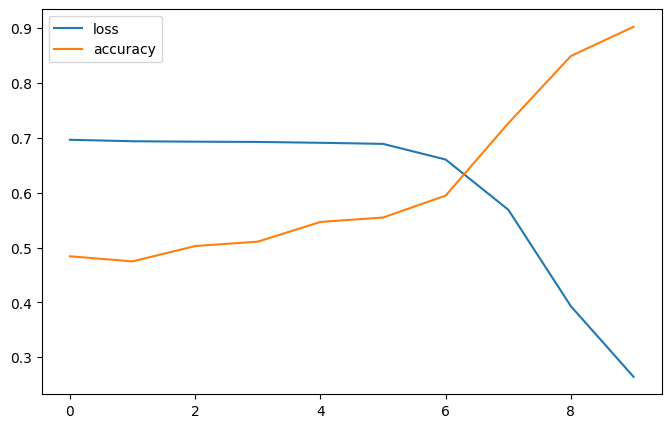

8/8 [==============================] - 0s 2ms/step


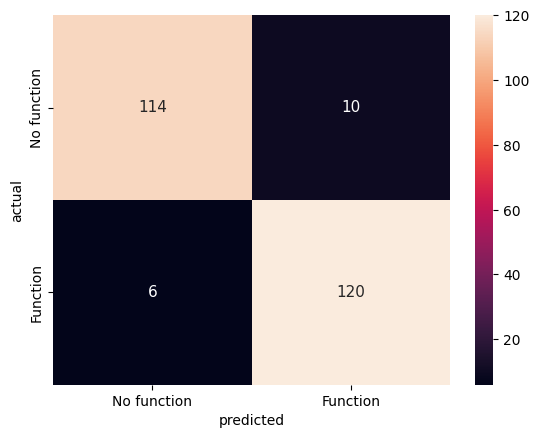

In [ ]:
# Reading the simulated data.
data_file = "len200_500_n1000"
seq_len = 500
trainXY, testXY = prep_simulated_data(data_file, 
                                      sequence_length=seq_len)
number_unique_tokens = 21

num_classes = 1
from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 128,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(# learning rate was 0.5
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
history = simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

import seaborn as sn
predictions = simulated_data_model.predict(X_test)
actual = tf.constant(Y_test)

cm = tf.math.confusion_matrix(labels=actual, 
                              predictions=np.rint(predictions))

df_map = {'No function': 0,
          'Function': 1}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.3g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()


8/8 [==============================] - 0s 2ms/step


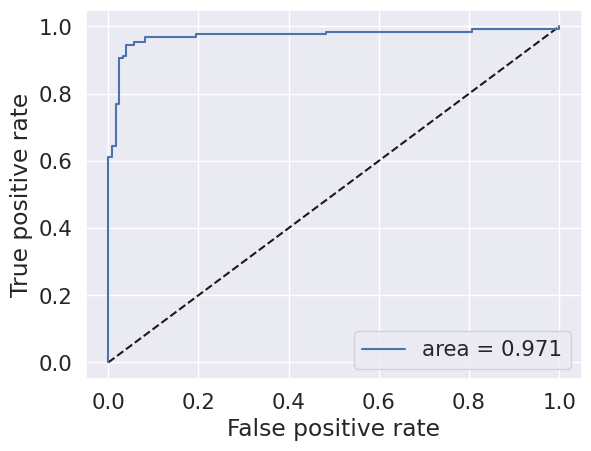

In [ ]:
plot_roc(simulated_data_model,
        Y_test, X_test)

## Experiments

###### Using different optimisers

In [ ]:
# Function to test optimiser.

def test_optimiser(dataset: str="len100_200_n1000",
                    seq_len=200,
                    optimiser=0.1):
    
    number_unique_tokens = 21
    num_classes = 1
    epochs = 10
    batch_size = 20

    optim = optimiser

    
    file_string=f"optimiser_{dataset}_{seq_len}_{optim}_{batch_size}_"

      
    
    K.clear_session()
    simulated_data_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(number_unique_tokens, 128,
                                  input_length=seq_len),
        tf.keras.layers.Conv1D(20,
                               5, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(30,
                               3, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(60,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes,
                              activation='sigmoid')
    ])
    simulated_data_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=optimiser),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    print(f"Model for {seq_len} aminoacids.\nDataset: {dataset}\optimiser fct: {optim}")
    
    def myprint(s):
        with open(file_string+'summary.txt','a') as f:
            print(s, file=f)
    summary=simulated_data_model.summary(print_fn=myprint)
    
    # Reading the smaller simulated data
    data_file = dataset
    trainXY, testXY = prep_simulated_data(data_file, 
                                          sequence_length=seq_len)
    X_train, Y_train = trainXY
    history = simulated_data_model.fit(X_train, Y_train,
                             epochs=epochs,
                             batch_size=batch_size)
    X_test, Y_test = testXY
    loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.savefig(file_string+"training.png", 
                bbox_inches='tight')
    plt.clf()
    
    import seaborn as sn
    predictions = simulated_data_model.predict(X_test)
    actual = tf.constant(Y_test)

    cm = tf.math.confusion_matrix(labels=actual, 
                                  predictions=np.rint(predictions))

    df_map = {'No function': 0,
              'Function': 1}
    df_cm = pd.DataFrame(cm.numpy(), 
                         index=list(df_map.keys()),
                         columns=list(df_map.keys()))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
                  fmt='.3g') # font size
    sn.set(font_scale=1.4) # for label size
    s.set_ylabel("actual")
    s.set_xlabel("predicted")
    plt.savefig(file_string+"confusion.png", 
            bbox_inches='tight')
    plt.clf()
    return accuracy


def test_optimisers(dataset: str="len100_200_n1000",
                           seq_len=200,
                           optimisers: list=[
                               0.1, 0.01, 0.001, 0.0001,
                           ]):
    
    test_performance = {'optimiser':[],
                        'performance': [],
                        'file': [dataset for x in range(len(optimisers))]}
    for optimiser in optimisers:
        optim = optimiser
        test_performance['optimiser'].append(optim)
        test_metric = test_optimiser(dataset=dataset,
                                      seq_len=seq_len,
                                      optimiser=optimiser)
        print(">>>", test_metric)
        test_performance['performance'].append(test_metric)
    return test_performance



In [ ]:
# Reading the smaller simulated data
data_file = "len100_200_n1000"
performance_optimiser_len100_200_n1000 = test_optimisers(dataset=data_file)

Model for 200 aminoacids.
Dataset: len100_200_n1000\optimiser fct: 0.1
Reading in simulated dataset len100_200_n1000
sequence: project_datasets/len100_200_n1000.seq
labels: project_datasets/len100_200_n1000.pos
Sequence length 200
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 3s 11ms/step - loss: 7.6636 - accuracy: 0.4827
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.4760
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4707
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5187
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4947
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4920
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5027
Epoch 8/10
38/38 [================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_optimiser_len100_200_n1000)

,optimiser,performance,file
0,0.1000,0.456,len100_200_n1000
1,0.0100,1.000,len100_200_n1000
2,0.0010,1.000,len100_200_n1000
3,0.0001,0.472,len100_200_n1000


In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n1000"
performance_optimiser_len200_500_n1000 = test_optimisers(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n1000\optimiser fct: 0.1
Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 4s 13ms/step - loss: 3.4881 - accuracy: 0.4693
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.5067
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5133
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5027
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.4787
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.5160
Epoch 8/10
38/38 [================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr1"
performance_optimiser_len200_500_n5000nr1 = test_optimisers(dataset=data_file, seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr1\optimiser fct: 0.1
Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 5ms/step - loss: 2.2398 - accuracy: 0.4869
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6988 - accuracy: 0.4925
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6956 - accuracy: 0.5077
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6963 - accuracy: 0.5040
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6954 - accuracy: 0.4885
Epoch 6/10
188/188 [==============================] - 1s 8ms/step - loss: 0.6965 - accuracy: 0.5008
Epoch 7/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6937 - accuracy: 0.5045
Epoch 8

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr2"
performance_optimiser_len200_500_n5000nr2 = test_optimisers(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr2\optimiser fct: 0.1
Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 4s 5ms/step - loss: 3.2795 - accuracy: 0.4923
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6940 - accuracy: 0.5027
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6982 - accuracy: 0.4880
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6949 - accuracy: 0.5067
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6956 - accuracy: 0.4952
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6960 - accuracy: 0.4936
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6955 - accuracy: 0.5000
Epoch 8

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr3"
performance_optimiser_len200_500_n5000nr3 = test_optimisers(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr3\optimiser fct: 0.1
Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 3.1297 - accuracy: 0.4904
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6954 - accuracy: 0.4987
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6954 - accuracy: 0.4955
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6965 - accuracy: 0.4949
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6955 - accuracy: 0.4949
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6958 - accuracy: 0.4933
Epoch 7/10
188/188 [==============================] - 1s 8ms/step - loss: 0.6966 - accuracy: 0.4891
Epoch 8

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr4"
performance_optimiser_len200_500_n5000nr4 = test_optimisers(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr4\optimiser fct: 0.1
Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 1.2975 - accuracy: 0.5027
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.5184
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.4901
Epoch 4/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6963 - accuracy: 0.4939
Epoch 5/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6977 - accuracy: 0.4939
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6964 - accuracy: 0.5115
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6962 - accuracy: 0.4955
Epoch 8

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

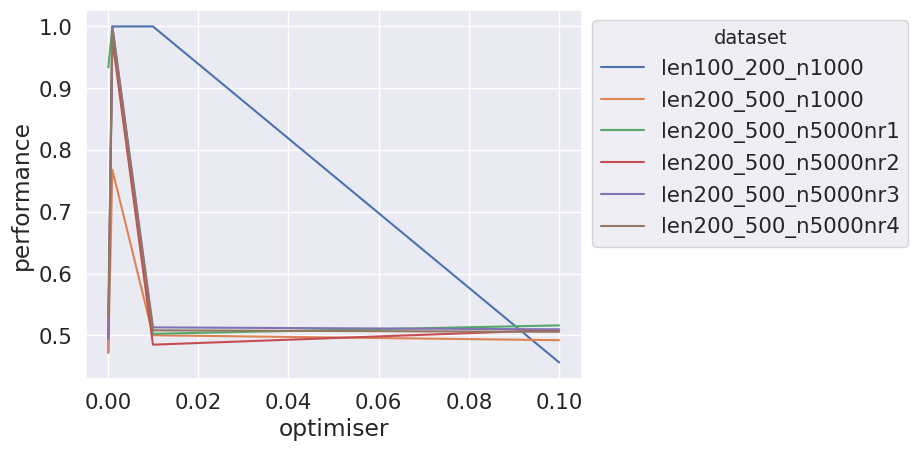

In [ ]:
# an overview of the kernel sizes.

optim_list = [performance_optimiser_len100_200_n1000,
              performance_optimiser_len200_500_n1000,
              performance_optimiser_len200_500_n5000nr1,
              performance_optimiser_len200_500_n5000nr2,
              performance_optimiser_len200_500_n5000nr3,
              performance_optimiser_len200_500_n5000nr4]
optim_df_list = [pd.DataFrame(x) for x in optim_list]
optim_results = pd.concat(optim_df_list,
                           ignore_index = True)
ax = sn.lineplot(data=optim_results,
                 x="optimiser",
                 y="performance",
                 hue="file")
plt.legend(title='dataset', fontsize='10', title_fontsize='14')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


#### Using different feature maps (outputs for Conv1D channels)

In [ ]:
# Function to test test_feature_maps

def test_feature_map(dataset: str="len100_200_n1000",
                    seq_len=200,
                    kernel_fct: int=1):
    
    number_unique_tokens = 21
    num_classes = 1
    epochs = 10
    batch_size = 20
    file_string=f"feature_{dataset}_{seq_len}_{kernel_fct}_{batch_size}_"

    
    
    K.clear_session()
    simulated_data_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(number_unique_tokens, 128,
                                  input_length=seq_len),
        tf.keras.layers.Conv1D(round(20*kernel_fct),
                               5, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(round(30*kernel_fct),
                               3, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(60,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes,
                              activation='sigmoid')
    ])
    simulated_data_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
        loss='binary_crossentropy',
        metrics=['accuracy'])
    print(f"Model for {seq_len} aminoacids.\nDataset: {dataset}\nkernel fct: {kernel_fct}")
    
    def myprint(s):
        with open(file_string+'summary.txt','a') as f:
            print(s, file=f)
    summary=simulated_data_model.summary(print_fn=myprint)
    
    # Reading the smaller simulated data
    data_file = dataset
    trainXY, testXY = prep_simulated_data(data_file, 
                                          sequence_length=seq_len)
    X_train, Y_train = trainXY
    history = simulated_data_model.fit(X_train, Y_train,
                             epochs=epochs,
                             batch_size=batch_size)
    X_test, Y_test = testXY
    loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.savefig(file_string+"training.png", 
                bbox_inches='tight')
    plt.clf()
    
    import seaborn as sn
    predictions = simulated_data_model.predict(X_test)
    actual = tf.constant(Y_test)

    cm = tf.math.confusion_matrix(labels=actual, 
                                  predictions=np.rint(predictions))

    df_map = {'No function': 0,
              'Function': 1}
    df_cm = pd.DataFrame(cm.numpy(), 
                         index=list(df_map.keys()),
                         columns=list(df_map.keys()))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
                  fmt='.3g') # font size
    sn.set(font_scale=1.4) # for label size
    s.set_ylabel("actual")
    s.set_xlabel("predicted")
    plt.savefig(file_string+"confusion.png", 
            bbox_inches='tight')
    plt.clf()
    return accuracy


def test_feature_map_range(dataset: str="len100_200_n1000",
                           seq_len=200,
                           kernel_fct: list=[0.25, 0.5, 1, 2, 4, 8]):
    test_performance = {'kernel_factor':[],
                        'performance': [],
                        'file': [dataset for x in range(len(kernel_fct))]}
    for kernel_fct_i in kernel_fct:
        test_performance['kernel_factor'].append(kernel_fct_i)
        test_metric = test_feature_map(dataset=dataset,
                                       seq_len=seq_len,
                                       kernel_fct=kernel_fct_i)
        print(">>>", test_metric)
        test_performance['performance'].append(test_metric)
    return test_performance



##### len100_200_n1000

In [ ]:
# Reading the smaller simulated data
data_file = "len100_200_n1000"
performance_kernels_len100_200_n1000 = test_feature_map_range(dataset=data_file)

Model for 200 aminoacids.
Dataset: len100_200_n1000
kernel fct: 0.25
Reading in simulated dataset len100_200_n1000
sequence: project_datasets/len100_200_n1000.seq
labels: project_datasets/len100_200_n1000.pos
Sequence length 200
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 4s 10ms/step - loss: 0.6945 - accuracy: 0.4973
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.4680
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5027
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5120
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5133
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5480
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.5893
Epoch 8/10
38/38 [==================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len100_200_n1000)

,kernel_factor,performance,file
0,0.25,0.452,len100_200_n1000
1,0.50,0.828,len100_200_n1000
2,1.00,1.000,len100_200_n1000
3,2.00,0.996,len100_200_n1000
4,4.00,0.992,len100_200_n1000
5,8.00,0.992,len100_200_n1000


##### len200_500_n1000

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n1000"
performance_kernels_len200_500_n1000 = test_feature_map_range(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n1000
kernel fct: 0.25
Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 3s 9ms/step - loss: 0.6941 - accuracy: 0.5173
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5213
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5160
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5373
Epoch 5/10
38/38 [==============================] - 0s 7ms/step - loss: 0.6862 - accuracy: 0.5227
Epoch 6/10
38/38 [==============================] - 0s 9ms/step - loss: 0.6808 - accuracy: 0.5707
Epoch 7/10
38/38 [==============================] - 0s 9ms/step - loss: 0.6660 - accuracy: 0.5800
Epoch 8/10
38/38 [===================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len200_500_n1000)

,kernel_factor,performance,file
0,0.25,0.480,len200_500_n1000
1,0.50,0.568,len200_500_n1000
2,1.00,0.980,len200_500_n1000
3,2.00,0.976,len200_500_n1000
4,4.00,0.988,len200_500_n1000
5,8.00,0.996,len200_500_n1000


##### len200_500_n5000nr1

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr1"
performance_kernels_len200_500_n5000nr1 = test_feature_map_range(dataset=data_file,
                                                                 seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr1
kernel fct: 0.25
Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 5ms/step - loss: 0.6939 - accuracy: 0.4973
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5053
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.5093
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3169 - accuracy: 0.8611
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0346 - accuracy: 0.9931
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0178 - accuracy: 0.9965
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0061 - accuracy: 0.9989
Epoch 8/1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len200_500_n5000nr1)

,kernel_factor,performance,file
0,0.25,1.0000,len200_500_n5000nr1
1,0.50,0.9976,len200_500_n5000nr1
2,1.00,0.9992,len200_500_n5000nr1
3,2.00,0.9960,len200_500_n5000nr1
4,4.00,0.9992,len200_500_n5000nr1
5,8.00,1.0000,len200_500_n5000nr1


##### len200_500_n5000nr2

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr2"
performance_kernels_len200_500_n5000nr2 = test_feature_map_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr2
kernel fct: 0.25
Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6939 - accuracy: 0.5005
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.5019
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6936 - accuracy: 0.5075
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6918 - accuracy: 0.5309
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6867 - accuracy: 0.5419
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6825 - accuracy: 0.5627
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6662 - accuracy: 0.5965
Epoch 8/1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len200_500_n5000nr2)

,kernel_factor,performance,file
0,0.25,0.4984,len200_500_n5000nr2
1,0.50,0.5312,len200_500_n5000nr2
2,1.00,0.4984,len200_500_n5000nr2
3,2.00,0.5024,len200_500_n5000nr2
4,4.00,0.5104,len200_500_n5000nr2
5,8.00,0.5088,len200_500_n5000nr2


##### len200_500_n5000nr3

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr3"
performance_kernels_len200_500_n5000nr3 = test_feature_map_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr3
kernel fct: 0.25
Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.4995
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5203
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5149
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.5723 - accuracy: 0.7245
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0760 - accuracy: 0.9851
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0239 - accuracy: 0.9963
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0115 - accuracy: 0.9981
Epoch 8/1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len200_500_n5000nr3)

,kernel_factor,performance,file
0,0.25,0.9968,len200_500_n5000nr3
1,0.50,0.9984,len200_500_n5000nr3
2,1.00,1.0000,len200_500_n5000nr3
3,2.00,1.0000,len200_500_n5000nr3
4,4.00,1.0000,len200_500_n5000nr3
5,8.00,0.9992,len200_500_n5000nr3


##### len200_500_n5000nr4

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr4"
performance_kernels_len200_500_n5000nr4 = test_feature_map_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr4
kernel fct: 0.25
Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.4968
Epoch 2/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6936 - accuracy: 0.4816
Epoch 3/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.4936
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.4920
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5144
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6634 - accuracy: 0.6085
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.3689 - accuracy: 0.8725
Epoch 8/1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_len200_500_n5000nr4)

,kernel_factor,performance,file
0,0.25,0.9936,len200_500_n5000nr4
1,0.50,0.7080,len200_500_n5000nr4
2,1.00,0.9952,len200_500_n5000nr4
3,2.00,0.4952,len200_500_n5000nr4
4,4.00,0.9992,len200_500_n5000nr4
5,8.00,0.9968,len200_500_n5000nr4


##### Summary

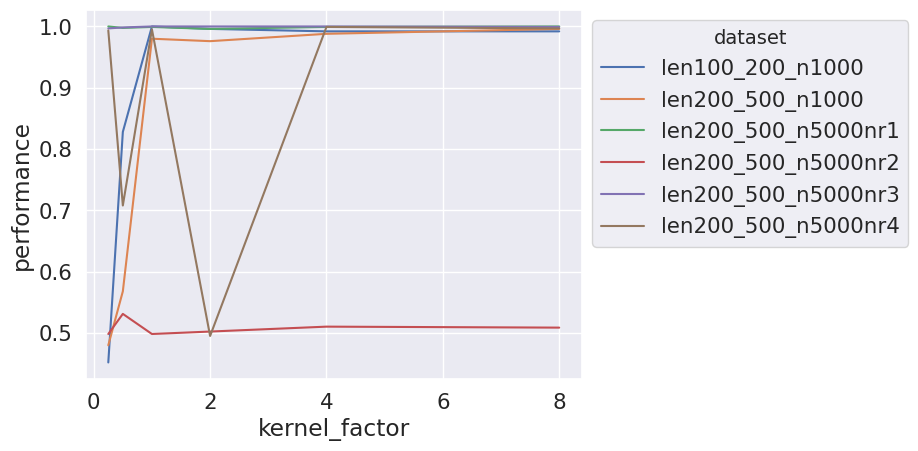

In [ ]:
# an overview of the kernel sizes.
kernel_list = [performance_kernels_len100_200_n1000,
                performance_kernels_len200_500_n1000,
                performance_kernels_len200_500_n5000nr1,
                performance_kernels_len200_500_n5000nr2,
                performance_kernels_len200_500_n5000nr3,
                performance_kernels_len200_500_n5000nr4]
kernel_df_list = [pd.DataFrame(x) for x in kernel_list]
kernel_df_results = pd.concat(kernel_df_list,
                           ignore_index = True)
ax = sn.lineplot(data=kernel_df_results,
                 x="kernel_factor",
                 y="performance",
                 hue="file")
plt.legend(title='dataset', fontsize='10', title_fontsize='14')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


#### Using different kernel sizes

In [ ]:
# Function to test test_feature_maps

def test_kernel_size(dataset: str="len100_200_n1000",
                    seq_len=200,
                    kernel_fct: int=1):
    
    number_unique_tokens = 21
    num_classes = 1
    epochs = 10
    batch_size = 20
    file_string=f"kernel_{dataset}_{seq_len}_{kernel_fct}_{batch_size}_"

    
    
    K.clear_session()
    simulated_data_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(number_unique_tokens, 128,
                                  input_length=seq_len),
        tf.keras.layers.Conv1D(20,
                               kernel_fct, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(30,
                               kernel_fct, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(60,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes,
                              activation='sigmoid')
    ])
    simulated_data_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
        loss='binary_crossentropy',
        metrics=['accuracy'])
    print(f"Model for {seq_len} aminoacids.\nDataset: {dataset}\nkernel fct: {kernel_fct}")
    
    def myprint(s):
        with open(file_string+'summary.txt','a') as f:
            print(s, file=f)
    summary=simulated_data_model.summary(print_fn=myprint)
    
    # Reading the smaller simulated data
    data_file = dataset
    trainXY, testXY = prep_simulated_data(data_file, 
                                          sequence_length=seq_len)
    X_train, Y_train = trainXY
    history = simulated_data_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
    X_test, Y_test = testXY
    loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.savefig(file_string+"training.png", bbox_inches='tight')
    plt.clf()
    
    import seaborn as sn
    predictions = simulated_data_model.predict(X_test)
    actual = tf.constant(Y_test)

    cm = tf.math.confusion_matrix(labels=actual, predictions=np.rint(predictions))

    df_map = {'No function': 0, 'Function': 1}
    df_cm = pd.DataFrame(cm.numpy(), index=list(df_map.keys()), columns=list(df_map.keys()))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11}, fmt='.3g') # font size
    sn.set(font_scale=1.4) # for label size
    s.set_ylabel("actual")
    s.set_xlabel("predicted")
    plt.savefig(file_string+"confusion.png", bbox_inches='tight')
    plt.clf()
    return accuracy


def test_kernel_size_range(dataset: str="len100_200_n1000", seq_len=200, kernel_fct: list=[5, 7, 10, 20, 30, 50]):
    test_performance = {'kernel_factor':[], 'performance': [], 'file': [dataset for x in range(len(kernel_fct))]}
    for kernel_fct_i in kernel_fct:
        try:
          test_performance['kernel_factor'].append(kernel_fct_i)
          test_metric = test_kernel_size(dataset=dataset, seq_len=seq_len, kernel_fct=kernel_fct_i)
          print(">>>", test_metric)
          test_performance['performance'].append(test_metric)
        except:
            print(kernel_fct_i, " did not work")
            test_performance['performance'].append(0)
    return test_performance



##### len100_200_n1000

In [ ]:
# Reading the smaller simulated data
data_file = "len100_200_n1000"
performance_kernels_size_len100_200_n1000 = test_kernel_size_range(dataset=data_file)

Model for 200 aminoacids.
Dataset: len100_200_n1000
kernel fct: 5
Reading in simulated dataset len100_200_n1000
sequence: project_datasets/len100_200_n1000.seq
labels: project_datasets/len100_200_n1000.pos
Sequence length 200
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 3s 10ms/step - loss: 0.6950 - accuracy: 0.4920
Epoch 2/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5173
Epoch 3/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5187
Epoch 4/10
38/38 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5080
Epoch 5/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6903 - accuracy: 0.5560
Epoch 6/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6811 - accuracy: 0.5573
Epoch 7/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6600 - accuracy: 0.6120
Epoch 8/10
38/38 [=====================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len100_200_n1000)

,kernel_factor,performance,file
0,5,0.992,len100_200_n1000
1,7,0.992,len100_200_n1000
2,10,0.984,len100_200_n1000
3,20,0.988,len100_200_n1000
4,30,0.992,len100_200_n1000
5,50,0.936,len100_200_n1000


##### len200_500_n1000

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n1000"
performance_kernels_size_len200_500_n1000 = test_kernel_size_range(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n1000
kernel fct: 5
Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 3s 9ms/step - loss: 0.6954 - accuracy: 0.4893
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5093
Epoch 3/10
38/38 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5453
Epoch 4/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6878 - accuracy: 0.5373
Epoch 5/10
38/38 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.5680
Epoch 6/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6153 - accuracy: 0.6720
Epoch 7/10
38/38 [==============================] - 0s 8ms/step - loss: 0.4515 - accuracy: 0.8173
Epoch 8/10
38/38 [======================

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len200_500_n1000)

,kernel_factor,performance,file
0,5,0.908,len200_500_n1000
1,7,0.848,len200_500_n1000
2,10,0.996,len200_500_n1000
3,20,0.492,len200_500_n1000
4,30,0.488,len200_500_n1000
5,50,0.984,len200_500_n1000


##### len200_500_n5000nr1

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr1"
performance_kernels_size_len200_500_n5000nr1 = test_kernel_size_range(dataset=data_file,
                                                                 seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr1
kernel fct: 5
Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6939 - accuracy: 0.5040
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4272 - accuracy: 0.8504
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0498 - accuracy: 0.9944
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0119 - accuracy: 0.9984
Epoch 5/10
188/188 [==============================] - 1s 7ms/step - loss: 0.0118 - accuracy: 0.9989
Epoch 6/10
188/188 [==============================] - 2s 9ms/step - loss: 0.0105 - accuracy: 0.9987
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0039 - accuracy: 0.9997
Epoch 8/10
1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len200_500_n5000nr1)

,kernel_factor,performance,file
0,5,1.0000,len200_500_n5000nr1
1,7,0.9992,len200_500_n5000nr1
2,10,0.9968,len200_500_n5000nr1
3,20,0.9992,len200_500_n5000nr1
4,30,0.9992,len200_500_n5000nr1
5,50,0.4976,len200_500_n5000nr1


##### len200_500_n5000nr2

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr2"
performance_kernels_size_len200_500_n5000nr2 = test_kernel_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr2
kernel fct: 5
Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6941 - accuracy: 0.4856
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6937 - accuracy: 0.4888
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5016
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5051
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5240
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.4827 - accuracy: 0.7624
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0716 - accuracy: 0.9848
Epoch 8/10
1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len200_500_n5000nr2)

,kernel_factor,performance,file
0,5,1.0000,len200_500_n5000nr2
1,7,0.5176,len200_500_n5000nr2
2,10,0.5072,len200_500_n5000nr2
3,20,0.5048,len200_500_n5000nr2
4,30,0.5016,len200_500_n5000nr2
5,50,0.5008,len200_500_n5000nr2


##### len200_500_n5000nr3

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr3"
performance_kernels_size_len200_500_n5000nr3 = test_kernel_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr3
kernel fct: 5
Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6938 - accuracy: 0.4885
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5029
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5091
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5011
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6933 - accuracy: 0.5101
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5048
Epoch 7/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6933 - accuracy: 0.5019
Epoch 8/10
1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len200_500_n5000nr3)

,kernel_factor,performance,file
0,5,0.5096,len200_500_n5000nr3
1,7,1.0000,len200_500_n5000nr3
2,10,1.0000,len200_500_n5000nr3
3,20,0.8200,len200_500_n5000nr3
4,30,0.4928,len200_500_n5000nr3
5,50,0.4912,len200_500_n5000nr3


##### len200_500_n5000nr4

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr4"
performance_kernels_size_len200_500_n5000nr4 = test_kernel_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr4
kernel fct: 5
Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6940 - accuracy: 0.4968
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.4931
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.4997
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6937 - accuracy: 0.5123
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.5099
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6938 - accuracy: 0.5136
Epoch 7/10
188/188 [==============================] - 2s 8ms/step - loss: 0.6926 - accuracy: 0.5091
Epoch 8/10
1

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_kernels_size_len200_500_n5000nr4)

,kernel_factor,performance,file
0,5,0.8016,len200_500_n5000nr4
1,7,1.0000,len200_500_n5000nr4
2,10,0.9712,len200_500_n5000nr4
3,20,0.5056,len200_500_n5000nr4
4,30,0.4880,len200_500_n5000nr4
5,50,0.4864,len200_500_n5000nr4


##### Summary

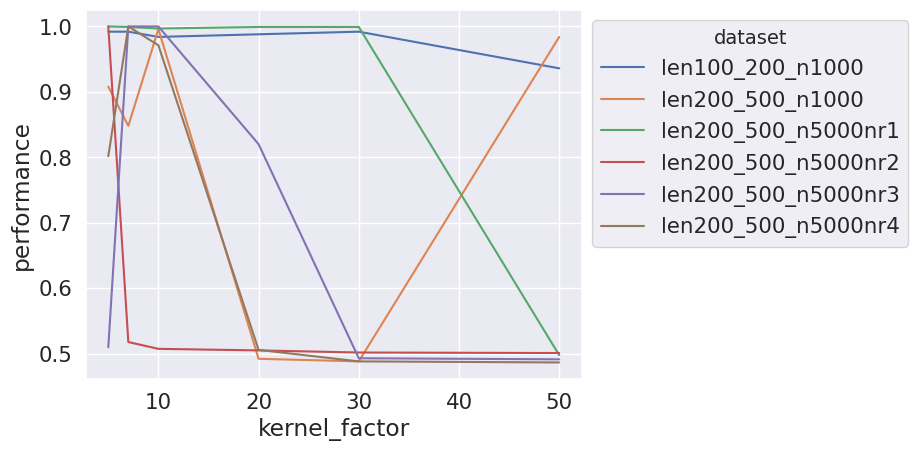

In [ ]:
# an overview of the kernel sizes.
kernel_list = [performance_kernels_size_len100_200_n1000,
                performance_kernels_size_len200_500_n1000,
                performance_kernels_size_len200_500_n5000nr1,
                performance_kernels_size_len200_500_n5000nr2,
                performance_kernels_size_len200_500_n5000nr3,
                performance_kernels_size_len200_500_n5000nr4]
kernel_df_list = [pd.DataFrame(x) for x in kernel_list]
kernel_df_results = pd.concat(kernel_df_list,
                           ignore_index = True)
ax = sn.lineplot(data=kernel_df_results,
                 x="kernel_factor",
                 y="performance",
                 hue="file")
plt.legend(title='dataset', fontsize='10', title_fontsize='14')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


####Using different batch sizes

In [ ]:
# Function to test batch sizes
def test_batch_size(dataset: str="len100_200_n1000",
                    seq_len=200,
                    batch_size: int=1):
    
    number_unique_tokens = 21
    num_classes = 1
    epochs = 20
    batch_size = batch_size
    file_string=f"batch_size_{dataset}_{seq_len}_{batch_size}_epochs_{epochs}"

    
    
    K.clear_session()
    simulated_data_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(number_unique_tokens, 128,
                                  input_length=seq_len),
        tf.keras.layers.Conv1D(20,
                               5, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(30,
                               3, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(60,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30,
                              activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes,
                              activation='sigmoid')
    ])
    simulated_data_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
        loss='binary_crossentropy',
        metrics=['accuracy'])
    print(f"Model for {seq_len} aminoacids.\nDataset: {dataset}\nbatch size: {batch_size}")
    
    def myprint(s):
        with open(file_string+'summary.txt','a') as f:
            print(s, file=f)
    summary=simulated_data_model.summary(print_fn=myprint)
    
    # Reading the smaller simulated data
    data_file = dataset
    trainXY, testXY = prep_simulated_data(data_file, 
                                          sequence_length=seq_len)
    X_train, Y_train = trainXY
    history = simulated_data_model.fit(X_train, Y_train,
                             epochs=epochs,
                             batch_size=batch_size)
    X_test, Y_test = testXY
    loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.savefig(file_string+"training.png", 
                bbox_inches='tight')
    plt.clf()
    
    import seaborn as sn
    predictions = simulated_data_model.predict(X_test)
    actual = tf.constant(Y_test)

    cm = tf.math.confusion_matrix(labels=actual, 
                                  predictions=np.rint(predictions))

    df_map = {'No function': 0,
              'Function': 1}
    df_cm = pd.DataFrame(cm.numpy(), 
                         index=list(df_map.keys()),
                         columns=list(df_map.keys()))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
                  fmt='.3g') # font size
    sn.set(font_scale=1.4) # for label size
    s.set_ylabel("actual")
    s.set_xlabel("predicted")
    plt.savefig(file_string+"confusion.png", 
            bbox_inches='tight')
    plt.clf()
    return accuracy


def test_batch_size_range(dataset: str="len100_200_n1000",
                           seq_len=200,
                           batch_size: list=[5, 10, 20, 30, 50]):
    test_performance = {'batch_size':[],
                        'performance': [],
                        'file': [dataset for x in range(len(batch_size))]}
    for batch_size_i in batch_size:
        test_performance['batch_size'].append(batch_size_i)
        test_metric = test_batch_size(dataset=dataset,
                                       seq_len=seq_len,
                                       batch_size=batch_size_i)
        print(">>>", test_metric)
        test_performance['performance'].append(test_metric)
    return test_performance


##### Calculation

In [ ]:
# Reading the smaller simulated data
data_file = "len100_200_n1000"
performance_batch_len100_200_n1000 = test_batch_size_range(dataset=data_file)

Model for 200 aminoacids.
Dataset: len100_200_n1000
batch size: 5
Reading in simulated dataset len100_200_n1000
sequence: project_datasets/len100_200_n1000.seq
labels: project_datasets/len100_200_n1000.pos
Sequence length 200
There are 750 sequences
There are 250 sequences
Epoch 1/20
150/150 [==============================] - 3s 5ms/step - loss: 0.6941 - accuracy: 0.5120
Epoch 2/20
150/150 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.4973
Epoch 3/20
150/150 [==============================] - 1s 5ms/step - loss: 0.6866 - accuracy: 0.5187
Epoch 4/20
150/150 [==============================] - 1s 5ms/step - loss: 0.2866 - accuracy: 0.8760
Epoch 5/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0519 - accuracy: 0.9867
Epoch 6/20
150/150 [==============================] - 1s 6ms/step - loss: 0.0413 - accuracy: 0.9933
Epoch 7/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0238 - accuracy: 0.9947
Epoch 8/20
150/150 [======

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n1000"
performance_batch_len200_500_n1000 = test_batch_size_range(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n1000
batch size: 5
Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Epoch 1/20
150/150 [==============================] - 3s 5ms/step - loss: 0.6955 - accuracy: 0.4853
Epoch 2/20
150/150 [==============================] - 1s 5ms/step - loss: 0.6936 - accuracy: 0.5200
Epoch 3/20
150/150 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5267
Epoch 4/20
150/150 [==============================] - 1s 7ms/step - loss: 0.6936 - accuracy: 0.5133
Epoch 5/20
150/150 [==============================] - 1s 6ms/step - loss: 0.6938 - accuracy: 0.5413
Epoch 6/20
150/150 [==============================] - 1s 5ms/step - loss: 0.6897 - accuracy: 0.5200
Epoch 7/20
150/150 [==============================] - 1s 5ms/step - loss: 0.6981 - accuracy: 0.5107
Epoch 8/20
150/150 [======

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr1"
performance_batch_len200_500_n5000nr1 = test_batch_size_range(dataset=data_file, seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr1
batch size: 5
Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/20
750/750 [==============================] - 6s 5ms/step - loss: 0.6941 - accuracy: 0.4960
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6934 - accuracy: 0.5096
Epoch 3/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6932 - accuracy: 0.5107
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6932 - accuracy: 0.5109
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6930 - accuracy: 0.5109
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6931 - accuracy: 0.5109
Epoch 7/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6930 - accuracy: 0.5109
Epoch 8/20
7

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr2"
performance_batch_len200_500_n5000nr2 = test_batch_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr2
batch size: 5
Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/20
750/750 [==============================] - 7s 6ms/step - loss: 0.6938 - accuracy: 0.5003
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6937 - accuracy: 0.4997
Epoch 3/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6934 - accuracy: 0.4979
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6935 - accuracy: 0.5064
Epoch 5/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6932 - accuracy: 0.5123
Epoch 6/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 7/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6932 - accuracy: 0.5080
Epoch 8/20
7

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr3"
performance_batch_len200_500_n5000nr3 = test_batch_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr3
batch size: 5
Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/20
750/750 [==============================] - 6s 5ms/step - loss: 0.6939 - accuracy: 0.4800
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6933 - accuracy: 0.4917
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6938 - accuracy: 0.4915
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.4073 - accuracy: 0.7760
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0257 - accuracy: 0.9936
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0159 - accuracy: 0.9963
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0101 - accuracy: 0.9987
Epoch 8/20
7

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr4"
performance_batch_len200_500_n5000nr4 = test_batch_size_range(dataset=data_file,
                                                                seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr4
batch size: 5
Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/20
750/750 [==============================] - 6s 5ms/step - loss: 0.6940 - accuracy: 0.4992
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6933 - accuracy: 0.5067
Epoch 3/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6935 - accuracy: 0.5021
Epoch 4/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6937 - accuracy: 0.4931
Epoch 5/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6943 - accuracy: 0.4949
Epoch 6/20
750/750 [==============================] - 3s 5ms/step - loss: 0.6932 - accuracy: 0.5064
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6937 - accuracy: 0.4928
Epoch 8/20
7

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

##### Summary

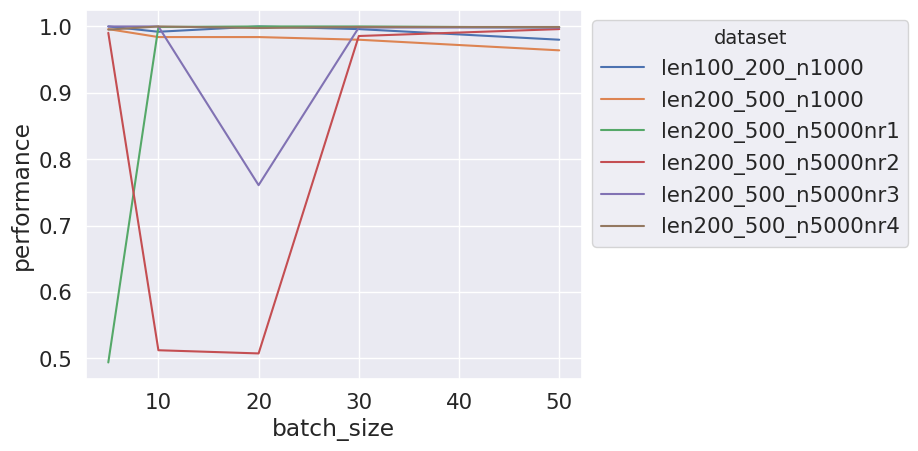

In [ ]:
# an overview of the kernel sizes.

batch_list = [performance_batch_len100_200_n1000,
                performance_batch_len200_500_n1000,
                performance_batch_len200_500_n5000nr1,
                performance_batch_len200_500_n5000nr2,
                performance_batch_len200_500_n5000nr3,
                performance_batch_len200_500_n5000nr4]
batch_df_list = [pd.DataFrame(x) for x in batch_list]
batch_results = pd.concat(batch_df_list,
                           ignore_index = True)
ax = sn.lineplot(data=batch_results,
                 x="batch_size",
                 y="performance",
                 hue="file")
plt.legend(title='dataset', fontsize='10', title_fontsize='14')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


#### Using different rate of dropout

In [ ]:
# Function to test kernel sizes
def test_dropout(dataset: str="len100_200_n1000",
                    seq_len=200,
                    dropout_fct: int=1):
    
    number_unique_tokens = 21
    num_classes = 1
    epochs = 10
    batch_size = 20
    file_string=f"dropout_{dataset}_{seq_len}_{dropout_fct}_{batch_size}_"  
    K.clear_session()
    simulated_data_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(number_unique_tokens, 128,
                                  input_length=seq_len),
        tf.keras.layers.Conv1D(20,
                               5, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(30,
                               3, activation='relu'),
        tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(60,
                              activation='relu'),
        tf.keras.layers.Dropout(1*dropout_fct),
        tf.keras.layers.Dense(30,
                              activation='relu'),
        tf.keras.layers.Dropout(1*dropout_fct),
        tf.keras.layers.Dense(num_classes,
                              activation='sigmoid')
    ])
    simulated_data_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
        loss='binary_crossentropy',
        metrics=['accuracy'])
    print(f"Model for {seq_len} aminoacids.\nDataset: {dataset}\dropout rate fct: {dropout_fct}")
    
    def myprint(s):
        with open(file_string+'summary.txt','a') as f:
            print(s, file=f)
    summary=simulated_data_model.summary(print_fn=myprint)
    
    # Reading the smaller simulated data
    data_file = dataset
    trainXY, testXY = prep_simulated_data(data_file, 
                                          sequence_length=seq_len)
    X_train, Y_train = trainXY
    history = simulated_data_model.fit(X_train, Y_train,
                             epochs=epochs,
                             batch_size=batch_size)
    X_test, Y_test = testXY
    loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.savefig(file_string+"training.png", 
                bbox_inches='tight')
    plt.clf()
    
    import seaborn as sn
    predictions = simulated_data_model.predict(X_test)
    actual = tf.constant(Y_test)

    cm = tf.math.confusion_matrix(labels=actual, 
                                  predictions=np.rint(predictions))

    df_map = {'No function': 0,
              'Function': 1}
    df_cm = pd.DataFrame(cm.numpy(), 
                         index=list(df_map.keys()),
                         columns=list(df_map.keys()))
    s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
                  fmt='.3g') # font size
    sn.set(font_scale=1.4) # for label size
    s.set_ylabel("actual")
    s.set_xlabel("predicted")
    plt.savefig(file_string+"confusion.png", 
            bbox_inches='tight')
    plt.clf()
    return accuracy


def test_dropout_range(dataset: str="len100_200_n1000",
                           seq_len=200,
                           dropout_fct: list=[0.1, 0.25, 0.5, 0.75, 0.90]):
    test_performance = {'dropout':[],
                        'performance': [],
                         'file': [dataset for x in range(len(dropout_fct))]}
    for dropout_fct_i in dropout_fct:
        test_performance['dropout'].append(dropout_fct_i)
        test_metric = test_dropout(dataset=dataset,
                                   seq_len=seq_len,
                                   dropout_fct=dropout_fct_i)
        print(">>>", test_metric)
        test_performance['performance'].append(test_metric)
    
    return test_performance



###### len100_200_n1000

In [ ]:
# Reading the smaller simulated data
data_file = "len100_200_n1000"
performance_dropout_len100_200_n1000 = test_dropout_range(dataset=data_file)

Model for 200 aminoacids.
Dataset: len100_200_n1000\dropout rate fct: 0.1
Reading in simulated dataset len100_200_n1000
sequence: project_datasets/len100_200_n1000.seq
labels: project_datasets/len100_200_n1000.pos
Sequence length 200
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 3s 8ms/step - loss: 0.6937 - accuracy: 0.5027
Epoch 2/10
38/38 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5253
Epoch 3/10
38/38 [==============================] - 0s 7ms/step - loss: 0.6753 - accuracy: 0.5680
Epoch 4/10
38/38 [==============================] - 0s 7ms/step - loss: 0.4148 - accuracy: 0.8333
Epoch 5/10
38/38 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.9813
Epoch 6/10
38/38 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9933
Epoch 7/10
38/38 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 8/10
38/38 [==============

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_dropout_len100_200_n1000)

,dropout,performance,file
0,0.10,1.000,len100_200_n1000
1,0.25,1.000,len100_200_n1000
2,0.50,0.996,len100_200_n1000
3,0.75,0.448,len100_200_n1000
4,0.90,0.480,len100_200_n1000


##### len200_500_n1000

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n1000"
performance_dropout_len200_500_n1000 = test_dropout_range(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n1000\dropout rate fct: 0.1
Reading in simulated dataset len200_500_n1000
sequence: project_datasets/len200_500_n1000.seq
labels: project_datasets/len200_500_n1000.pos
Sequence length 500
There are 750 sequences
There are 250 sequences
Epoch 1/10
38/38 [==============================] - 2s 6ms/step - loss: 0.6949 - accuracy: 0.4720
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5160
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5640
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6553 - accuracy: 0.6533
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.5458 - accuracy: 0.7320
Epoch 6/10
38/38 [==============================] - 0s 5ms/step - loss: 0.3727 - accuracy: 0.8400
Epoch 7/10
38/38 [==============================] - 0s 6ms/step - loss: 0.2167 - accuracy: 0.9187
Epoch 8/10
38/38 [==============

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_dropout_len200_500_n1000)

,dropout,performance,file
0,0.10,0.608,len200_500_n1000
1,0.25,0.968,len200_500_n1000
2,0.50,0.992,len200_500_n1000
3,0.75,0.964,len200_500_n1000
4,0.90,0.488,len200_500_n1000


##### len200_500_n5000nr1

In [ ]:
# Reading the smaller simulated data
data_file = "len200_500_n5000nr1"
performance_dropout_len200_500_n5000nr1 = test_dropout_range(dataset=data_file, 
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr1\dropout rate fct: 0.1
Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.5064
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.2691 - accuracy: 0.8872
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0086 - accuracy: 0.9981
Epoch 4/10
188/188 [==============================] - 1s 7ms/step - loss: 0.0032 - accuracy: 0.9997
Epoch 5/10
188/188 [==============================] - 2s 8ms/step - loss: 6.7588e-04 - accuracy: 1.0000
Epoch 6/10
188/188 [==============================] - 1s 7ms/step - loss: 3.4768e-04 - accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 1.3224e-04 - accuracy:

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

##### len200_500_n5000nr2

In [ ]:
# Reading the smaller simulated data
data_file = "len200_500_n5000nr2"
performance_dropout_len200_500_n5000nr2 = test_dropout_range(dataset=data_file, 
                                                             seq_len=500)


Model for 500 aminoacids.
Dataset: len200_500_n5000nr2\dropout rate fct: 0.1
Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6937 - accuracy: 0.5032
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.5019
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6927 - accuracy: 0.5101
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.6870 - accuracy: 0.5448
Epoch 5/10
188/188 [==============================] - 2s 8ms/step - loss: 0.3308 - accuracy: 0.8595
Epoch 6/10
188/188 [==============================] - 1s 8ms/step - loss: 0.0221 - accuracy: 0.9947
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 1.0000
Epoc

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_dropout_len200_500_n5000nr2)

,dropout,performance,file
0,0.10,0.9984,len200_500_n5000nr2
1,0.25,0.5840,len200_500_n5000nr2
2,0.50,0.5136,len200_500_n5000nr2
3,0.75,0.5104,len200_500_n5000nr2
4,0.90,0.5280,len200_500_n5000nr2


##### len200_500_n5000nr3

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr3"
performance_dropout_len200_500_n5000nr3 = test_dropout_range(dataset=data_file,
                                                             seq_len=500)


Model for 500 aminoacids.
Dataset: len200_500_n5000nr3\dropout rate fct: 0.1
Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 4s 5ms/step - loss: 0.6932 - accuracy: 0.5080
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5003
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5189
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4909 - accuracy: 0.7400
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0141 - accuracy: 0.9973
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 4.1767e-04 - accuracy: 1.0000


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_dropout_len200_500_n5000nr3)

,dropout,performance,file
0,0.10,0.9992,len200_500_n5000nr3
1,0.25,1.0000,len200_500_n5000nr3
2,0.50,0.9992,len200_500_n5000nr3
3,0.75,0.4968,len200_500_n5000nr3
4,0.90,0.4944,len200_500_n5000nr3


##### len200_500_n5000nr4

In [ ]:
# Reading the larger simulated data
data_file = "len200_500_n5000nr4"
performance_dropout_len200_500_n5000nr4 = test_dropout_range(dataset=data_file,
                                                             seq_len=500)

Model for 500 aminoacids.
Dataset: len200_500_n5000nr4\dropout rate fct: 0.1
Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Epoch 1/10
188/188 [==============================] - 3s 6ms/step - loss: 0.6940 - accuracy: 0.4939
Epoch 2/10
188/188 [==============================] - 1s 5ms/step - loss: 0.6923 - accuracy: 0.5155
Epoch 3/10
188/188 [==============================] - 1s 7ms/step - loss: 0.5308 - accuracy: 0.7371
Epoch 4/10
188/188 [==============================] - 2s 8ms/step - loss: 0.0880 - accuracy: 0.9757
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0123 - accuracy: 0.9968
Epoch 6/10
188/188 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 6.6920e-04 - accuracy: 1.0000


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
pd.DataFrame(performance_dropout_len200_500_n5000nr4)

,dropout,performance,file
0,0.10,0.9952,len200_500_n5000nr4
1,0.25,0.9968,len200_500_n5000nr4
2,0.50,0.9976,len200_500_n5000nr4
3,0.75,1.0000,len200_500_n5000nr4
4,0.90,0.4896,len200_500_n5000nr4


##### Summary

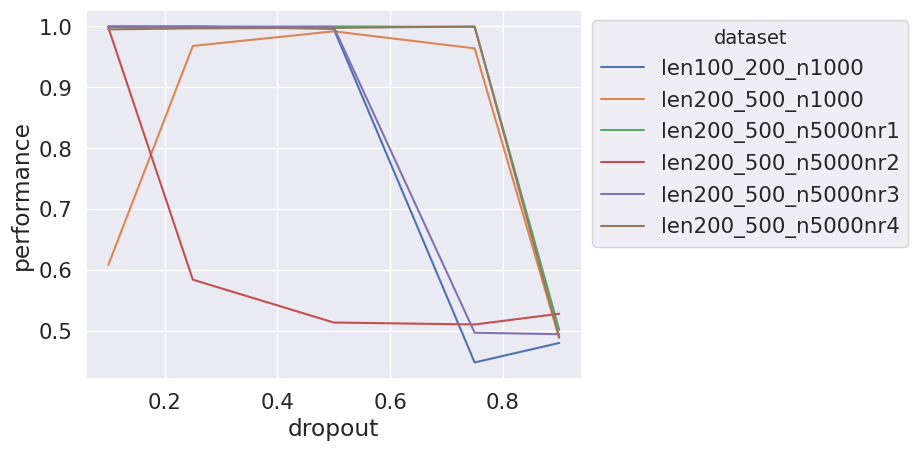

In [ ]:
# an overview of the dropout rates.
dropout_list = [performance_dropout_len100_200_n1000,
                performance_dropout_len200_500_n1000,
                performance_dropout_len200_500_n5000nr1,
                performance_dropout_len200_500_n5000nr2,
                performance_dropout_len200_500_n5000nr3,
                performance_dropout_len200_500_n5000nr4]
dropout_df_list = [pd.DataFrame(x) for x in dropout_list]
dropout_results = pd.concat(dropout_df_list,
                           ignore_index = True)
ax = sn.lineplot(data=dropout_results,
                 x="dropout",
                 y="performance",
                 hue="file")
plt.legend(title='dataset', fontsize='10', title_fontsize='14')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### Performance on different datasets


##### Dataset len200_500_n5000nr1

In [ ]:

number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr1"
trainXY, testXY = prep_simulated_data(data_file)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr1
sequence: project_datasets/len200_500_n5000nr1.seq
labels: project_datasets/len200_500_n5000nr1.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 average_pooling1d_1 (Averag  (None

##### Dataset len200_500_n5000nr2

In [ ]:
number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr2"
trainXY, testXY = prep_simulated_data(data_file)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 20
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr2
sequence: project_datasets/len200_500_n5000nr2.seq
labels: project_datasets/len200_500_n5000nr2.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 average_pooling1d_1 (Averag  (None

##### Dataset len200_500_n5000nr3

In [ ]:
number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr3"
trainXY, testXY = prep_simulated_data(data_file)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr3
sequence: project_datasets/len200_500_n5000nr3.seq
labels: project_datasets/len200_500_n5000nr3.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 average_pooling1d_1 (Averag  (None

##### Dataset len200_500_n5000nr4

In [ ]:
number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr4"
trainXY, testXY = prep_simulated_data(data_file)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Sequence length 500
There are 3750 sequences
There are 1250 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 30)           1830      
                                                                 
 average_pooling1d_1 (Averag  (None

### Investigate the influence of label balance on prediction 


In [ ]:
Removal of the 

In [ ]:

def prep_filtered_data(name,filter_value= 1, prob = 0.5):
    """filter half of the targeted sequences with function(filter_value = 1)
       filter half of the targeted sequences with no function(filter_value = 0)
    """
    
    print(f"Reading in simulated dataset {name}")
    
    base = "project_datasets/"

    data = read_simulated_data(base + name + ".seq",
                               base+name+".pos")
    print(f"Total number of seq: {len(data)}")
    num_steps = max_length(data)
    print(f"Sequence length {num_steps}")
    data_targeted = [tup for tup in data if tup[1] == filter_value]
    print(f"Total number of functional seq: {len(data_targeted)}")
    data_untargeted = [tup for tup in data if tup[1] == 1-filter_value] 
    print(f"Total number of unannotated seq: {len(data_untargeted)}")
    random.shuffle(data_targeted)
    data_targeted_filtered = data_targeted[0:len(data_targeted)//2]
    data_filtered = data_targeted_filtered + data_untargeted
    print(f"Total number after filtered {len(data_filtered)}")
    train_filtered, test_filtered = generate_train_test(data_filtered, 0.25)
    aa = list("ACDEFGHIKLMNPQRSTVWY")
    X_train, Y_train = load_data_tf(num_steps,
                                    train_filtered,
                                    amino_acids=aa)
    X_test, Y_test = load_data_tf(num_steps,
                                  test_filtered,
                                  amino_acids=aa)
    return (X_train, Y_train), (X_test, Y_test)

In [ ]:
number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr4"
trainXY, testXY = prep_filtered_data(data_file)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Total number of seq: 5000
Sequence length 500
Total number of functional seq: 2490
Total number of unannotated seq: 2510
Total number after filtered 3755
There are 2817 sequences
There are 938 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None

30/30 [==============================] - 0s 2ms/step


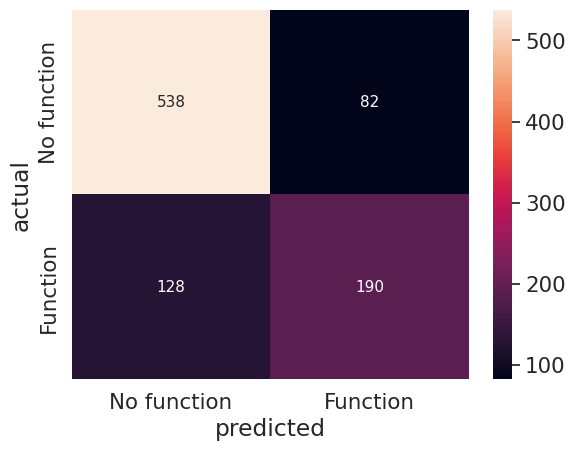

In [ ]:
import seaborn as sn
predictions = simulated_data_model.predict(X_test)
actual = tf.constant(Y_test)

cm = tf.math.confusion_matrix(labels=actual, 
                              predictions=np.rint(predictions))

df_map = {'No function': 0,
          'Function': 1}

df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.3g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

In [ ]:
number_unique_tokens = 21
seq_len = 500
num_classes = 1

data_file = "len200_500_n5000nr4"
trainXY, testXY = prep_filtered_data(data_file, 0)

from keras import backend as K
K.clear_session()
simulated_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 32,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='sigmoid')
])
simulated_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0010), # I changed the lr
    loss='binary_crossentropy',
    metrics=['accuracy'])
simulated_data_model.summary()
epochs = 10
batch_size = 20
X_train, Y_train = trainXY
simulated_data_model.fit(X_train, Y_train,
                         epochs=epochs,
                         batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = simulated_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in simulated dataset len200_500_n5000nr4
sequence: project_datasets/len200_500_n5000nr4.seq
labels: project_datasets/len200_500_n5000nr4.pos
Total number of seq: 5000
Sequence length 500
Total number of functional seq: 2510
Total number of unannotated seq: 2490
Total number after filtered 3745
There are 2809 sequences
There are 936 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           672       
                                                                 
 conv1d (Conv1D)             (None, 496, 20)           3220      
                                                                 
 average_pooling1d (AverageP  (None, 248, 20)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None

30/30 [==============================] - 0s 2ms/step


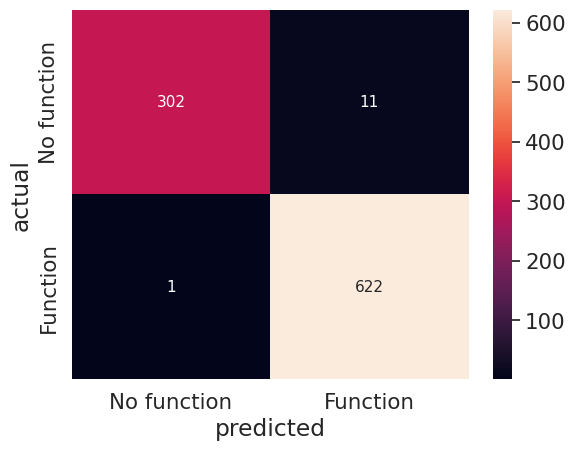

In [ ]:
import seaborn as sn
predictions = simulated_data_model.predict(X_test)
actual = tf.constant(Y_test)

cm = tf.math.confusion_matrix(labels=actual, 
                              predictions=np.rint(predictions))

df_map = {'No function': 0,
          'Function': 1}

df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.3g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

# Human dataset

Here we attempt to work on the human dataset.

In [ ]:
def prep_human_data(name="expr5Tseq_filtGO_100-1000.lis"):
    """Reading in a dataset of human data
    """
    print(f"Reading in human dataset {name}")  
    base = "project_datasets/"
    data = read_human_data()
    num_steps = max_length(data) -1
    print(f"Sequence length {num_steps}")
    train_data, test_data = generate_train_test(data, 0.25)
    aa = list("ACDEFGHIKLMNPQRSTVWYX")
    X_train, Y_train = load_data_tf(num_steps,
                                    train_data,
                                    amino_acids=aa)
    X_test, Y_test = load_data_tf(num_steps,
                                  test_data,
                                  amino_acids=aa)
    return (X_train, Y_train), (X_test, Y_test)

def prep_human_data_filtered(filter_values:list,
                             probs:list,
                             name="expr5Tseq_filtGO_100-1000.lis"):
    """Reading in a dataset of human data
    remove most of the unknown class
    probs are the probabilities for how much data would be removed in each class
    """
    
    print(f"Reading in human dataset {name}")
    
    base = "project_datasets/"

    data = read_human_data()
    
    num_steps = max_length(data) -1
    data_targeted_filtered_all = []
    print(f"Sequence length {num_steps}")
    for filter_value,prob in zip(filter_values,probs):
      data_targeted = [(x, y) for x, y in data if y == filter_value]
      print(f"Total number of No. {filter_value} class: {len(data_targeted)}")
      random.shuffle(data_targeted)
      data_targeted_filtered = data_targeted[0:int(len(data_targeted)*prob)]
      data_targeted_filtered_all += data_targeted_filtered
     
    data_untargeted = [(x,y) for x, y in data if (x,y) not in data_targeted_filtered_all]
    print(f"Total number of filtered data {len(data_untargeted)}")
    # TODO: randomely remove some of the unknown classes.
    train_data, test_data = generate_train_test(data_untargeted, 0.33)
    aa = list("ACDEFGHIKLMNPQRSTVWYX")
    X_train, Y_train = load_data_tf(num_steps,
                                    train_data,
                                    amino_acids=aa)
    X_test, Y_test = load_data_tf(num_steps,
                                  test_data,
                                  amino_acids=aa)
    return (X_train, Y_train), (X_test, Y_test)

def prep_human_data_filtered_all_class(name="expr5Tseq_filtGO_100-1000.lis",
                             filter_value=5):
    """Reading in a dataset of human data
    remove most of the unknown class
    """
    
    print(f"Reading in human dataset {name}")
    
    base = "project_datasets/"

    data = read_human_data()
    
    num_steps = max_length(data) -1
    print(f"Sequence length {num_steps}")
    data_targeted = [(x, y) for x, y in data if y == filter_value]
    print(f"Total number of filtered class: {len(data_targeted)}")
    data_untargeted = [(x,y) for x, y in data if y != filter_value]
    print(f"Total number of other classes: {len(data_untargeted)}")
    data_filtered = data_untargeted
    print(f"Total number of filtered data {len(data_filtered)}")
    # TODO: randomely remove some of the unknown classes.
    train_data, test_data = generate_train_test(data_filtered, 0.33)
    aa = list("ACDEFGHIKLMNPQRSTVWYX")
    X_train, Y_train = load_data_tf(num_steps,
                                    train_data,
                                    amino_acids=aa)
    X_test, Y_test = load_data_tf(num_steps,
                                  test_data,
                                  amino_acids=aa)
    return (X_train, Y_train), (X_test, Y_test)


Reading in simulated dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0043066', 'GO_3A0005739', 'GO_3A0055085', 'GO_3A0007165', 'GO_3A0005576', 'other'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
   GO_3A0007165  GO_3A0005576  GO_3A0055085  GO_3A0005739  GO_3A0043066  other
0             0             1             2             3             4      5
1           376           307           200           424           147   5330


<ipython-input-14-5b4497527920>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_overview,


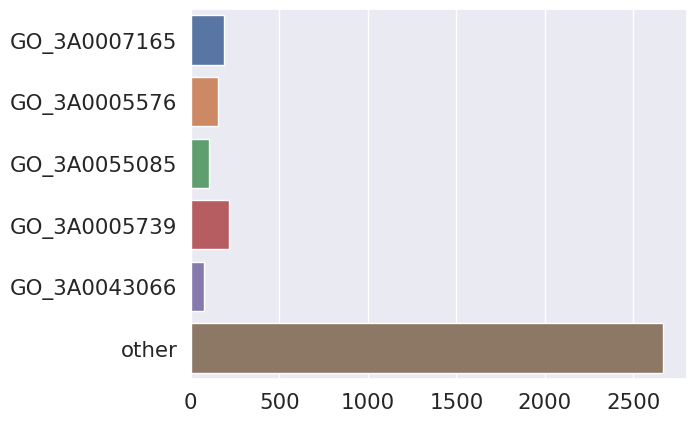

In [ ]:
# A plot of class distribution
def get_number_plot(data):
   
    classes = [x[1] for x in data]
    np.array(classes)
    df_map = {'GO_3A0007165': 0,
              'GO_3A0005576': 1,
              'GO_3A0055085': 2,
              'GO_3A0005739': 3,
              'GO_3A0043066': 4,
              'other': 5}
    unique, counts = np.unique(classes, return_counts=True)
    counts = np.asarray((unique, counts))
    data_overview = pd.DataFrame(counts, 
                                 columns = list(df_map))
    print(data_overview)
    sns.barplot(data=data_overview,
               ci=None,
              orient="h")
name = "expr5Tseq_filtGO_100-1000.lis"
print(f"Reading in simulated dataset {name}")
base = "project_datasets/"
data = read_human_data()
get_number_plot(data)

## Human dataset balanced labels

### remove 95% of the unknown class in human data

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0005576', 'GO_3A0005739', 'GO_3A0055085', 'GO_3A0007165', 'GO_3A0043066', 'other'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of No. 5 class: 5330
Total number of filtered data 1721
There are 1154 sequences
There are 567 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 conv1d (Conv1D)             (None, 996, 10)           5010      
                                                                 
 average_pooling1d (AverageP  (None, 498, 10)          0         
 ooling1D)                                                       
                                                     

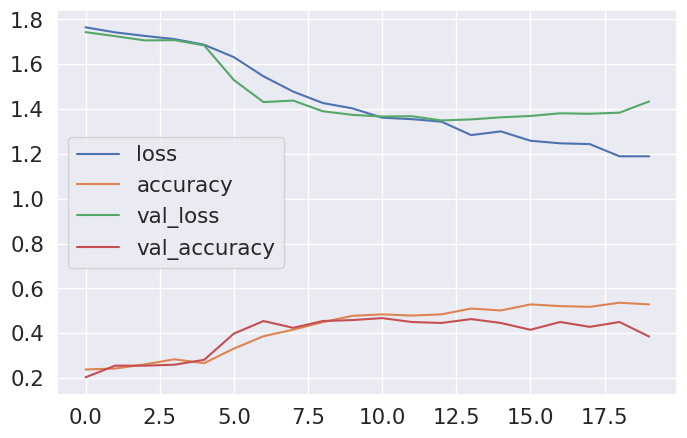

18/18 [==============================] - 0s 3ms/step


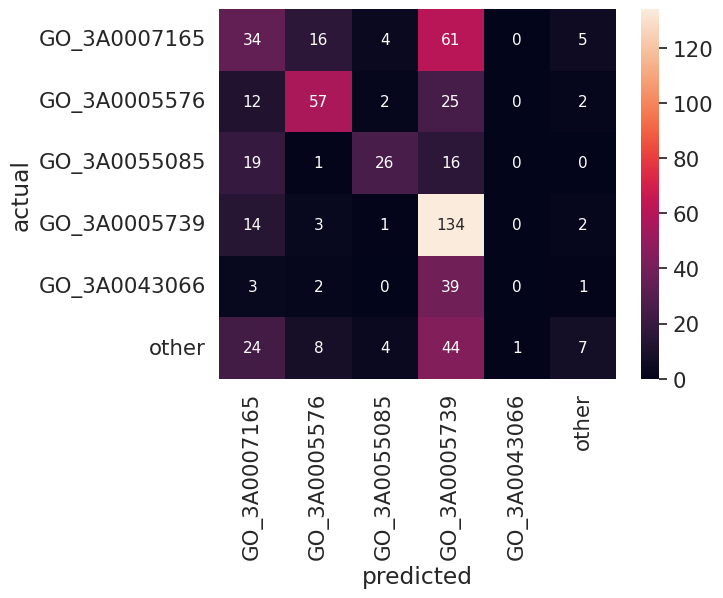

In [ ]:
filter_values = [5]
probs = [0.95]
human_trainXY, human_testXY = prep_human_data_filtered(filter_values,probs)

number_unique_tokens = 22
seq_len = 1000
num_classes = 6


from keras import backend as K
K.clear_session()

human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(10, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4), # added a pool layer here!
    tf.keras.layers.Flatten(), # If we change the dropout rate
    tf.keras.layers.Dropout(0.6), # The acc is closer to test.
    tf.keras.layers.Dense(120,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # I changed the lr, lowered it.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs = 20
batch_size = 20
human_X_train, human_Y_train = human_trainXY
history = human_data_model.fit(human_X_train, 
                               human_Y_train,
                               epochs=epochs,
                               validation_split=0.2,
                               shuffle=True,
                               batch_size=batch_size)
human_X_test, human_Y_test = human_testXY
loss, accuracy = human_data_model.evaluate(human_X_test,
                                           human_Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model.predict(human_X_test)
actual = tf.constant(human_Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)

df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4, 
          'other': 5}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

18/18 [==============================] - 0s 2ms/step


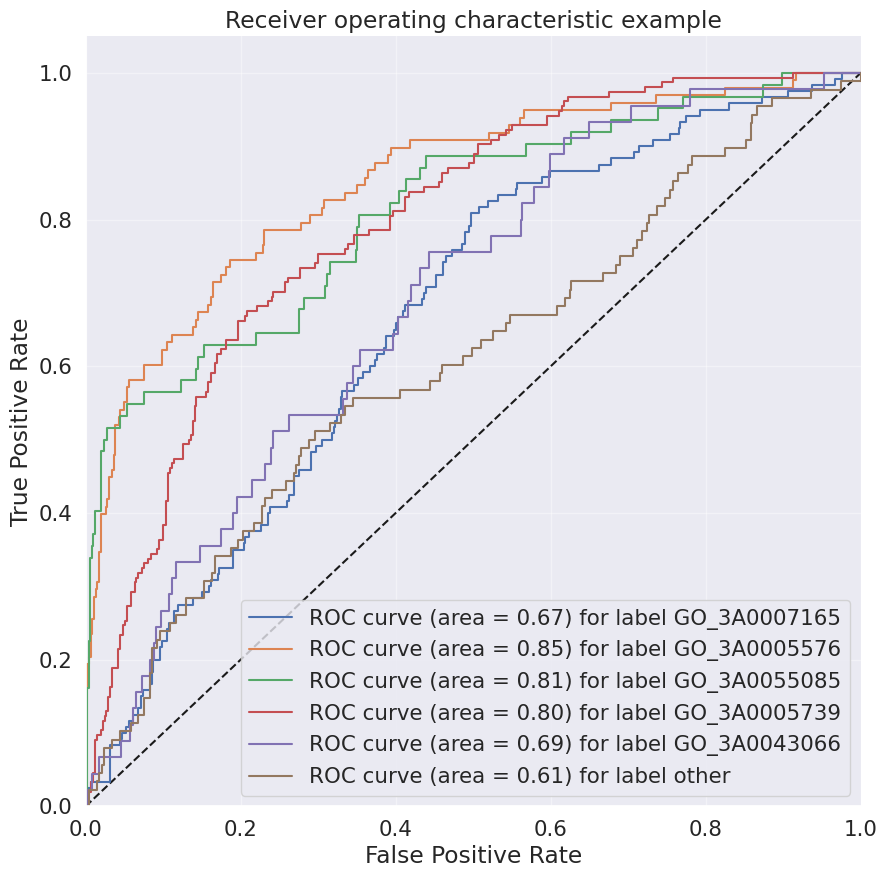

In [ ]:
plot_multiclass_roc(human_data_model,
                    human_X_test,
                    human_Y_test,
                    n_classes=6,
                    figsize=(10, 10))

### This is the original model from simulated data (with 90% of other removed)

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0005739', 'GO_3A0007165', 'GO_3A0055085', 'GO_3A0005576', 'other', 'GO_3A0043066'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of No. 5 class: 5330
Total number of filtered data 1987
There are 1332 sequences
There are 655 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         2816      
                                                                 
 conv1d (Conv1D)             (None, 996, 20)           12820     
                                                                 
 average_pooling1d (AverageP  (None, 498, 20)          0         
 ooling1D)                                                       
                                                     

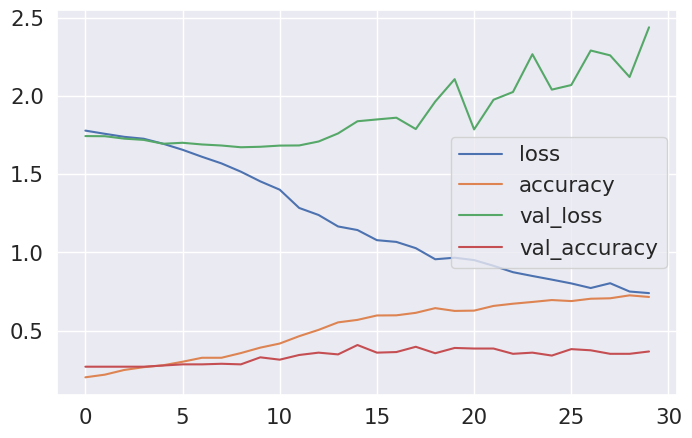

21/21 [==============================] - 0s 2ms/step


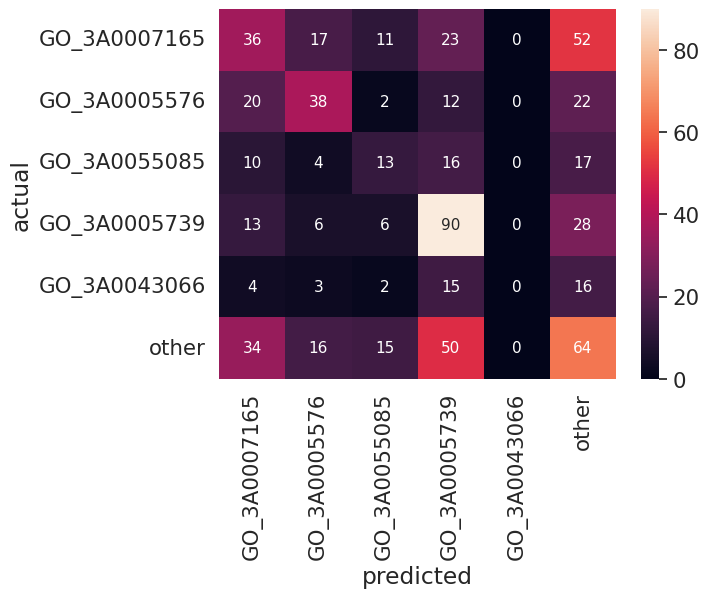

In [ ]:
filter_values = [5]
probs = [0.9]
human_trainXY, human_testXY = prep_human_data_filtered(filter_values,
                                                      probs)

number_unique_tokens = 22
seq_len = 1000
num_classes = 6

from keras import backend as K
K.clear_session()
human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 128,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])
human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # I changed the lr, lowered it.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs = 30
batch_size = 20
human_X_train, human_Y_train = human_trainXY
history = human_data_model.fit(human_X_train, 
                               human_Y_train,
                               epochs=epochs,
                               validation_split=0.2,
                               shuffle=True,
                               batch_size=batch_size)
human_X_test, human_Y_test = human_testXY
loss, accuracy = human_data_model.evaluate(human_X_test,
                                           human_Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
human_data_model_90 = human_data_model
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model.predict(human_X_test)
actual = tf.constant(human_Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)

df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4, 
          'other': 5}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

### remove 90% of the unknown class in human data

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0005739', 'GO_3A0007165', 'GO_3A0055085', 'GO_3A0005576', 'other', 'GO_3A0043066'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of No. 5 class: 5330
Total number of filtered data 1987
There are 1332 sequences
There are 655 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 conv1d (Conv1D)             (None, 996, 10)           5010      
                                                                 
 average_pooling1d (AverageP  (None, 498, 10)          0         
 ooling1D)                                                       
                                                     

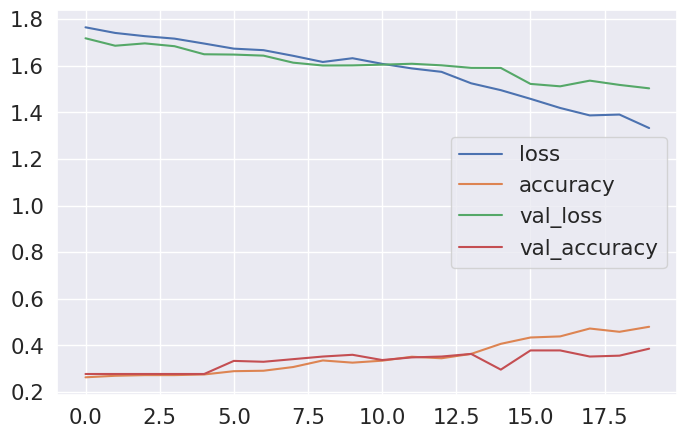

21/21 [==============================] - 0s 2ms/step


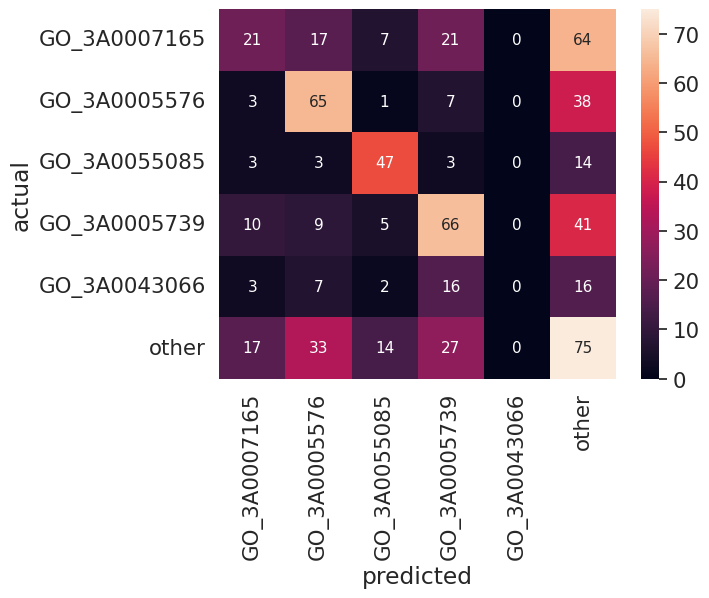

In [ ]:
sfilter_values = [5]
probs = [0.9]
human_trainXY, human_testXY = prep_human_data_filtered(filter_values,
                                                      probs)

number_unique_tokens = 22
seq_len = 1000
num_classes = 6


from keras import backend as K
K.clear_session()

human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(10, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4), # added a pool layer here!
    tf.keras.layers.Flatten(), # If we change the dropout rate
    tf.keras.layers.Dropout(0.6), # The acc is closer to test.
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # I changed the lr, lowered it.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs = 20
batch_size = 20
human_X_train, human_Y_train = human_trainXY
history = human_data_model.fit(human_X_train, 
                               human_Y_train,
                               epochs=epochs,
                               validation_split=0.2,
                               shuffle=True,
                               batch_size=batch_size)
human_X_test, human_Y_test = human_testXY
loss, accuracy = human_data_model.evaluate(human_X_test,
                                           human_Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
human_data_model_90 = human_data_model
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model.predict(human_X_test)
actual = tf.constant(human_Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)

df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4, 
          'other': 5}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

21/21 [==============================] - 0s 2ms/step


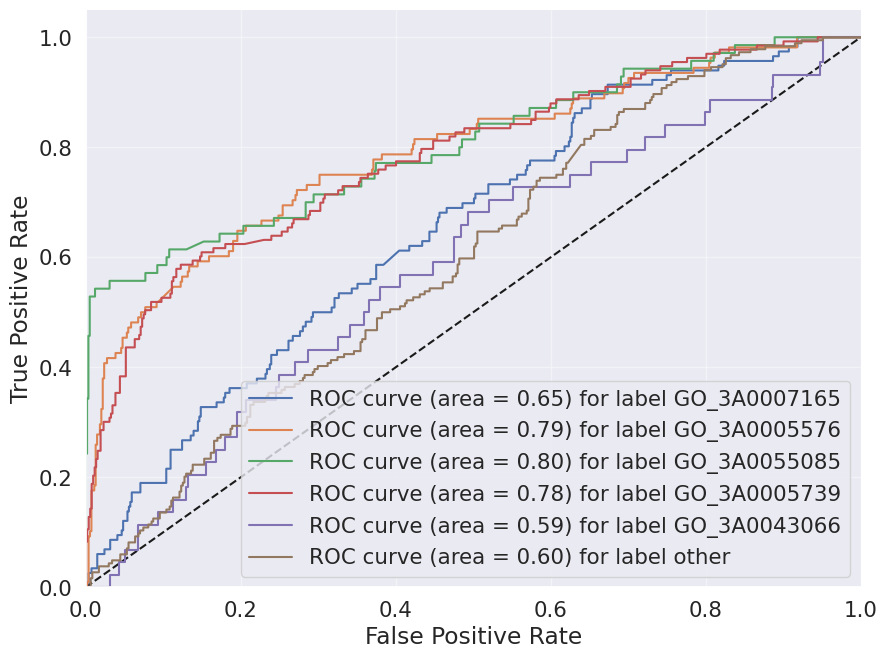

In [ ]:
plot_multiclass_roc(human_data_model,
                    human_X_test,
                    human_Y_test,
                    n_classes=6,
                    figsize=(10, 7.5))

### LSTM model for 90%-unknown-removed data

In [ ]:
filter_values = [5]
probs = [0.9]
trainXY, testXY = prep_human_data_filtered(filter_values,
                                                      probs)

number_unique_tokens = 22
seq_len = 1000
num_classes = 6

from keras import backend as K
K.clear_session()

human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(120,activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs =20
batch_size = 20
X_train, Y_train = trainXY
history = human_data_model.fit(X_train, Y_train,
                                   epochs=epochs,
                                   validation_split=0.2,
                                   shuffle=True,
                                   batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = human_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'other', 'GO_3A0043066', 'GO_3A0055085', 'GO_3A0005739', 'GO_3A0005576', 'GO_3A0007165'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of No. 5 class: 5330
Total number of filtered data 1987
There are 1332 sequences
There are 655 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 lstm (LSTM)                 (None, 1000, 64)          42240     
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dropout (Dropout)           (None, 64000)           

### GRU model for 90%-unknown-removed data

In [ ]:
filter_values = [5]
probs = [0.9]
trainXY, testXY = prep_human_data_filtered(filter_values,
                                                      probs)

number_unique_tokens = 22
seq_len = 1000
num_classes = 6

from keras import backend as K
K.clear_session()

human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.GRU(64,return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6), 
    tf.keras.layers.Dense(120,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs =20
batch_size = 20
X_train, Y_train = trainXY
history = human_data_model.fit(X_train, Y_train,
                                   epochs=epochs,
                                   validation_split=0.2,
                                   shuffle=True,
                                   batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = human_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'other', 'GO_3A0043066', 'GO_3A0055085', 'GO_3A0005739', 'GO_3A0005576', 'GO_3A0007165'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of No. 5 class: 5330
Total number of filtered data 1987
There are 1332 sequences
There are 655 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 gru (GRU)                   (None, 1000, 64)          31872     
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dropout (Dropout)           (None, 64000)           

### remove all the unknown classes in human data
### We get 60% accuracy 

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0005739', 'GO_3A0007165', 'GO_3A0055085', 'GO_3A0005576', 'other', 'GO_3A0043066'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of filtered class: 5330
Total number of other classes: 1454
Total number of filtered data 1454
There are 975 sequences
There are 479 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 conv1d (Conv1D)             (None, 996, 10)           5010      
                                                                 
 average_pooling1d (AverageP  (None, 498, 10)          0         
 ooling1D)                                                       
               

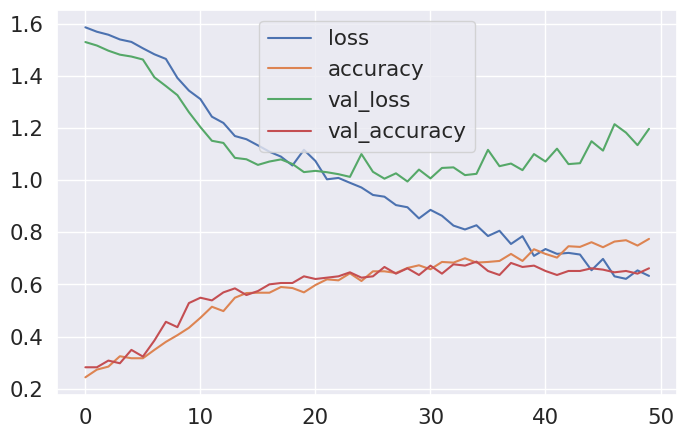

15/15 [==============================] - 0s 3ms/step


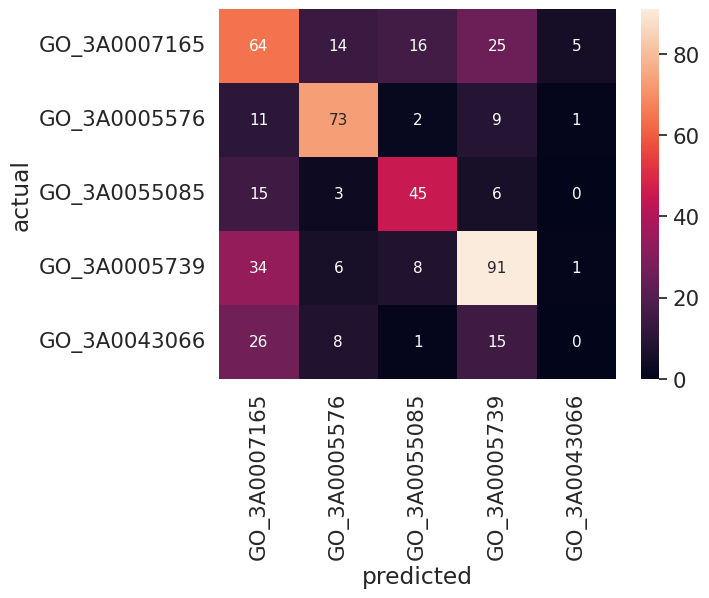

In [ ]:
human_trainXY, human_testXY = prep_human_data_filtered_all_class(filter_value=5)

number_unique_tokens = 22
seq_len = 1000
num_classes = 5


from keras import backend as K
K.clear_session()

human_data_model_60 = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(10, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model_60.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # I changed the lr, lowered it.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model_60.summary()
epochs = 50
batch_size = 20
human_X_train, human_Y_train = human_trainXY
history = human_data_model_60.fit(human_X_train, 
                               human_Y_train,
                               epochs=epochs,
                               validation_split=0.2,
                               shuffle=True,
                               batch_size=batch_size)
human_X_test, human_Y_test = human_testXY
loss, accuracy = human_data_model_60.evaluate(human_X_test,
                                           human_Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model_60.predict(human_X_test)
actual = tf.constant(human_Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)

df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

15/15 [==============================] - 0s 7ms/step


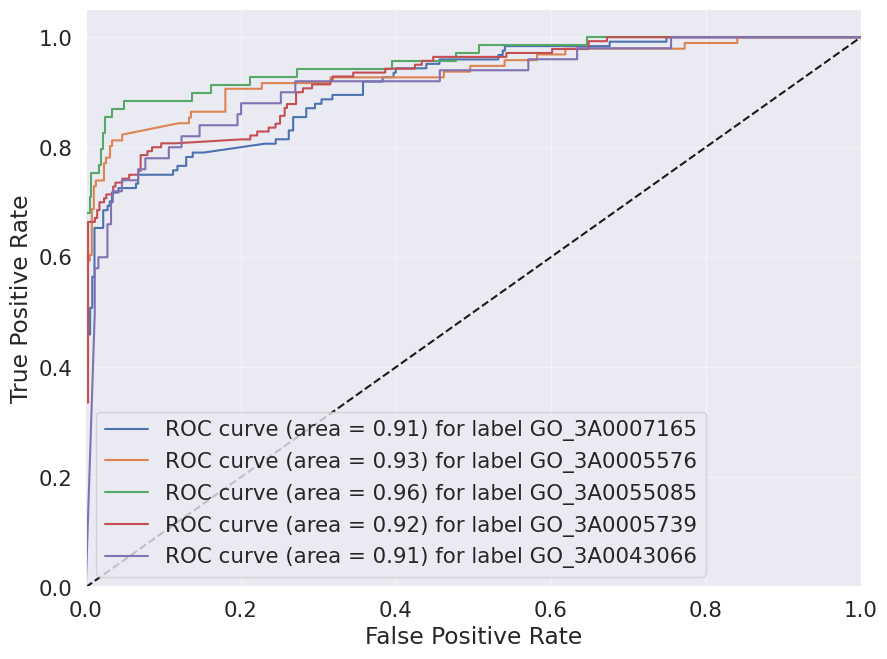

In [ ]:
plot_multiclass_roc(human_data_model,
                    human_X_test,
                    human_Y_test,
                    n_classes=5,
                    figsize=(10, 7.5))

### increase the kernel size (kernel size * 5)
#### does not improve the performance 

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0055085', 'GO_3A0005739', 'GO_3A0043066', 'GO_3A0005576', 'other', 'GO_3A0007165'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
Total number of filtered class: 5330
Total number of other classes: 1454
Total number of filtered data 1454
There are 975 sequences
There are 479 sequences
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 conv1d (Conv1D)             (None, 976, 10)           25010     
                                                                 
 average_pooling1d (AverageP  (None, 488, 10)          0         
 ooling1D)                                                       
               

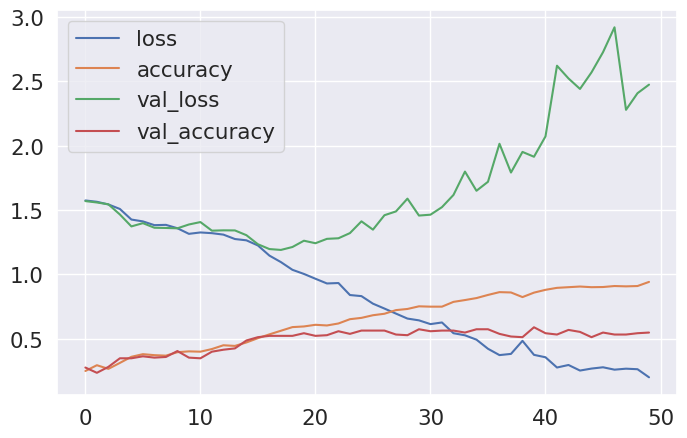

15/15 [==============================] - 0s 2ms/step


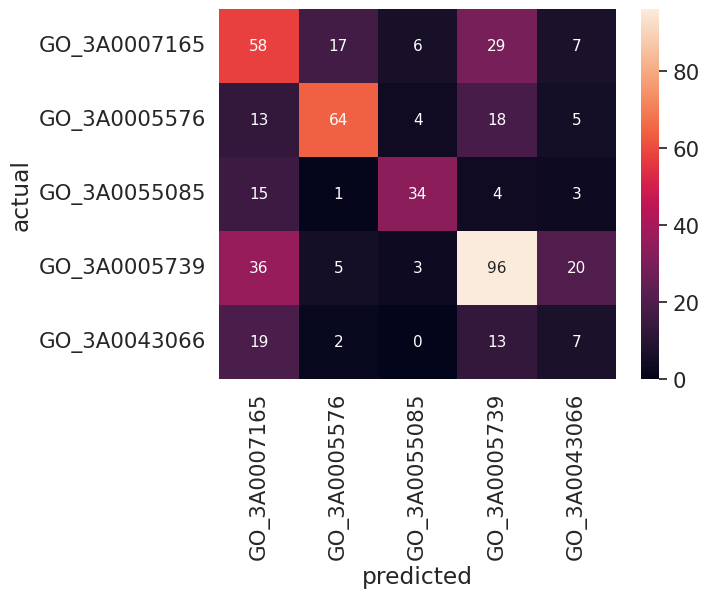

In [ ]:
human_trainXY, human_testXY = prep_human_data_filtered_all_class(filter_value=5)

number_unique_tokens = 22
seq_len = 1000
num_classes = 5


from keras import backend as K
K.clear_session()

human_data_model_60 = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(10, 25, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(20, 25, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 15, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(120,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model_60.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # I changed the lr, lowered it.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model_60.summary()
epochs = 50
batch_size = 20
human_X_train, human_Y_train = human_trainXY
history = human_data_model_60.fit(human_X_train, 
                               human_Y_train,
                               epochs=epochs,
                               validation_split=0.2,
                               shuffle=True,
                               batch_size=batch_size)
human_X_test, human_Y_test = human_testXY
loss, accuracy = human_data_model_60.evaluate(human_X_test,
                                           human_Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model_60.predict(human_X_test)
actual = tf.constant(human_Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)

df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

## Human dataset (whole)

In [ ]:
trainXY, testXY = prep_human_data()
print(testXY[0])

Reading in human dataset expr5Tseq_filtGO_100-1000.lis
{'GO_3A0005739', 'GO_3A0007165', 'GO_3A0055085', 'GO_3A0005576', 'other', 'GO_3A0043066'}
map is
{'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
Sequence length 1000
There are 5088 sequences
There are 1696 sequences
tf.Tensor(
[[10.  5. 14. ... 21. 21. 21.]
 [10.  0. 16. ... 21. 21. 21.]
 [10. 15.  5. ... 21. 21. 21.]
 ...
 [10.  8. 12. ... 21. 21. 21.]
 [10.  6.  5. ... 21. 21. 21.]
 [10.  0.  5. ... 21. 21. 21.]], shape=(1696, 1000), dtype=float32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         2200      
                                                                 
 conv1d (Conv1D)             (None, 996, 10)           5010      
                                                                 
 average_pooling1d (AverageP  (None, 498, 10)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 494, 20)           1020      
                                                                 
 average_pooling1d_1 (Averag  (None, 247, 20)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 245, 30)           1

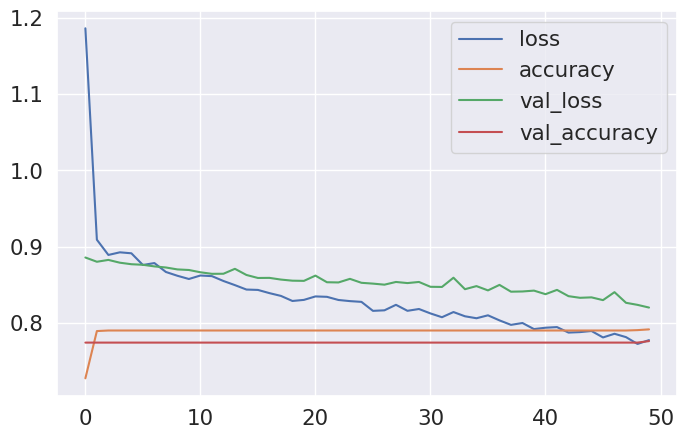

53/53 [==============================] - 0s 2ms/step


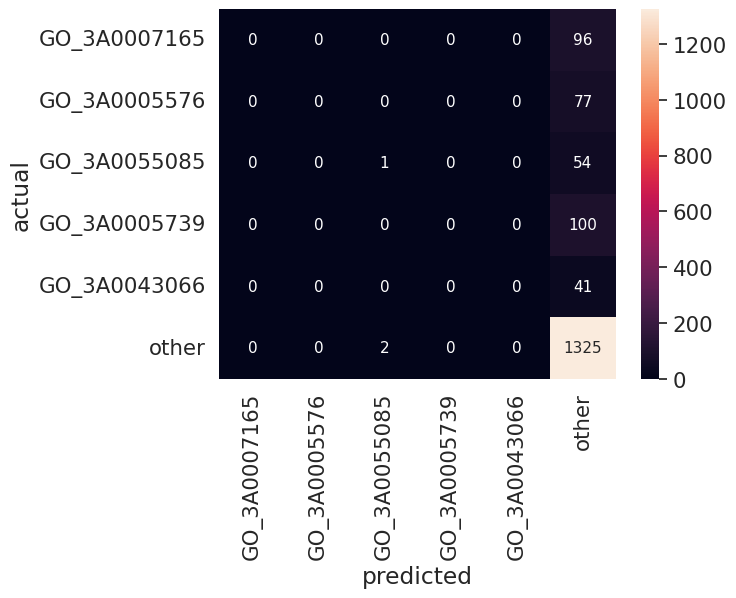

In [ ]:
number_unique_tokens = 22
seq_len = 1000
num_classes = 6


from keras import backend as K
K.clear_session()
human_data_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(number_unique_tokens, 100,
                              input_length=seq_len),
    tf.keras.layers.Conv1D(10, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(20, 5, activation='relu'),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Conv1D(30, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4), # added a pool layer here!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(60,
                          activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(30,
                          activation='relu'),
    tf.keras.layers.Dense(num_classes,
                          activation='softmax')
])

human_data_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # I changed the lr
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
human_data_model.summary()
epochs = 50
batch_size = 20
X_train, Y_train = trainXY
history = human_data_model.fit(X_train, Y_train,
                                   epochs=epochs,
                                   validation_split=0.2,
                                   shuffle=True,
                                   batch_size=batch_size)
X_test, Y_test = testXY
loss, accuracy = human_data_model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
figsize = (24,
           12)
import seaborn as sn
predictions = human_data_model.predict(X_test)
actual = tf.constant(Y_test)
predicted_indexes = tf.math.argmax(predictions, 1)

cm = tf.math.confusion_matrix(actual, predicted_indexes)
df_map = {'GO_3A0007165': 0,
          'GO_3A0005576': 1,
          'GO_3A0055085': 2,
          'GO_3A0005739': 3,
          'GO_3A0043066': 4, 
          'other': 5}
df_cm = pd.DataFrame(cm.numpy(), 
                     index=list(df_map.keys()),
                     columns=list(df_map.keys()))
sn.set(font_scale=1.4) # for label size
s = sn.heatmap(df_cm, annot=True, annot_kws={"size": 11},
              fmt='.4g') # font size
sn.set(font_scale=1.4) # for label size
s.set_ylabel("actual")
s.set_xlabel("predicted")
plt.show()

21/21 [==============================] - 0s 2ms/step


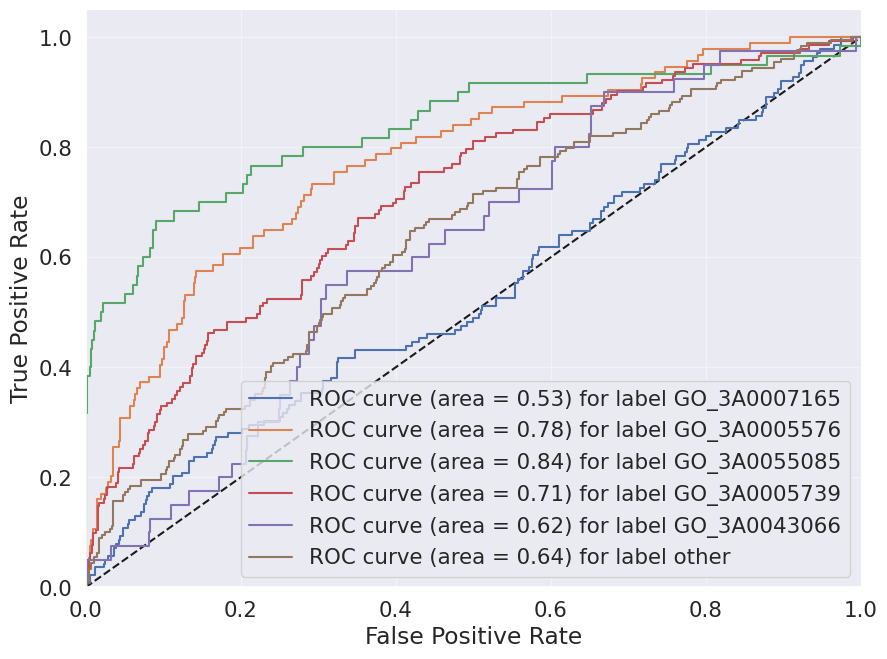

In [ ]:
plot_multiclass_roc(human_data_model,
                    human_X_test,
                    human_Y_test,
                    n_classes=6,
                    figsize=(10, 7.5))

# Prediction dataset

In this part, we use our 90% other class removed model to predict on the prediction set.

In [ ]:
# Load from FASTA
from collections import Counter

def read_fasta(dataset: str):
    """Reading a fasta file as a list of tuples.
    
    """
    fasta_sequences = SeqIO.parse(open(dataset),'fasta')
    out = []
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        out.append((name, sequence,))
    return out


def load_data_from_fasta(dataset: str="project_datasets/test_set_filt.f",
                         amino_acids=list("ACDEFGHIKLMNPQRSTVWYX"),
                         num_steps=1000):
  """Dataloader from fasta file.
  """
  amino_acids = amino_acids
  mapaa2num = {aa: i for (i, aa) in enumerate(amino_acids)}
  seq_data = read_fasta(dataset)
  seqs = [x[1] for x in seq_data]
  ids = [x[0] for x in seq_data]
  print(f"There are {len(seqs)} sequences")
  seq_tokens = []
  for seq in seqs:
    tokens = [x[0] for x in tokenize(seq, mapaa2num)]
    tensor_tokens = truncate_pad(tokens, num_steps, len(amino_acids))
    seq_tokens.append(tensor_tokens)
  X_tensor = tf.convert_to_tensor(list(seq_tokens),
                      dtype=tf.float32)
  return X_tensor, ids


def classification_rule(y_pred, mode="argmax"):
  classifications = None
  if mode=="argmax":
    classifications = tf.math.argmax(y_pred, 1).numpy()
  return classifications

class_map = {'GO_3A0007165': 0, 'GO_3A0005576': 1, 'GO_3A0055085': 2, 'GO_3A0005739': 3, 'GO_3A0043066': 4, 'other': 5}
inv_map = {v: k for k, v in class_map.items()}


In [ ]:
X_data, X_ids = load_data_from_fasta()

There are 14765 sequences


In [ ]:
y_pred = human_data_model.predict(X_data)

462/462 [==============================] - 2s 4ms/step


In [ ]:
classifications = classification_rule(y_pred)
classes = [inv_map[x] for x in classifications]

In [ ]:
classes_count = pd.DataFrame(Counter(classes), index = range(1))
classes_count

,GO_3A0005739,GO_3A0055085,other,GO_3A0007165,GO_3A0005576
0,6947,512,4368,765,2173


Text(0, 0.5, 'Frequency')

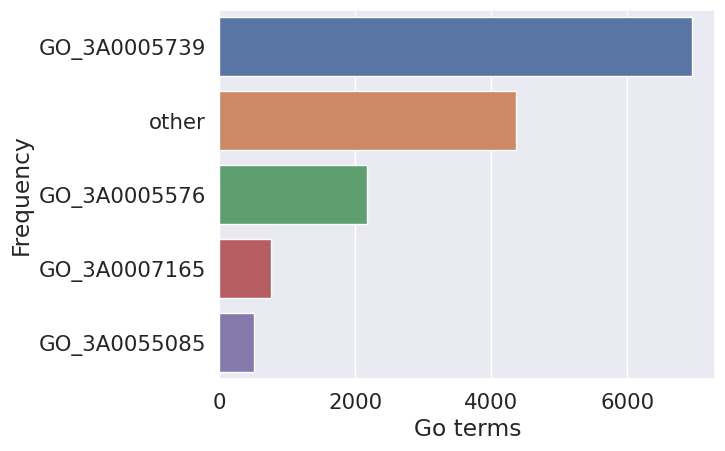

In [ ]:
ordered_classes = pd.DataFrame({k: v for k, v in sorted(Counter(classes).items(), 
                                                       key=lambda x: x[1],
                                                       reverse=True)},
                               index=range(1))
sn.barplot(ordered_classes, orient="h")
plt.xlabel("Go terms")
plt.ylabel("Frequency")